In [1]:
%matplotlib inline

In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt
import glob,gc,os

In [3]:
from matplotlib.patheffects import withStroke

In [4]:
# Information for TIGRESS synthetic maps
# dust polarization maps at 353 GHz can be downloaded at https://lambda.gsfc.nasa.gov/simulation/tb_tigress_data.cfm
data_folder = '../data/allsky_maps/'

# 9 observer positions
observers = ['x0y0z0','x-256y0z0','x256y0z0',
             'x0y-256z0','x-256y-256z0','x256y-256z0',
             'x0y256z0','x-256y256z0','x256y256z0']

# 350 snapshots to process
itimes=np.arange(300,650,dtype=int)

In [5]:
# pandas and xarray are used to handle data
import pandas as pd
import xarray as xr
# seaborn is used for plotting
import seaborn as sns

In [76]:
# for |b|>30
bcut = 'b30'
with xr.open_dataset('../data/all_cls.nc') as dset:
    avg=dset.sel(leff=slice(80,120)).mean(dim='leff')

# for |b|>60
# bcut = 'b60'
# with xr.open_dataset('../data/all_cls.b60.nc') as dset:
#     avg=dset.sel(leff=slice(80,120)).mean(dim='leff')

In [77]:
ratio=xr.Dataset()
ratio['EEBB'] = avg['EE']/avg['BB']
ratio['rTE'] = avg['TE']/np.sqrt(avg['TT']*avg['EE'])
ratio['rTB'] = avg['TB']/np.sqrt(avg['TT']*avg['BB'])
ratio['rEB'] = avg['EB']/np.sqrt(avg['BB']*avg['EE'])

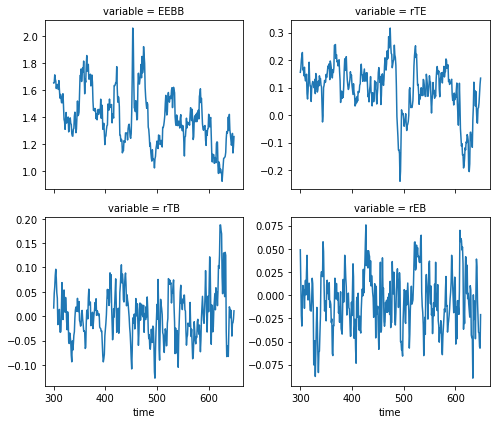

In [78]:
ratio.mean(dim='observer').to_array().plot(col='variable',sharey=False,col_wrap=2)

In [79]:
# convert to pandas dataframe to use seaborn pairplot
dlist=[]
for i,obs in enumerate(observers):
    df = ratio.sel(observer=i).to_array().to_pandas()
    ob=pd.Series(np.zeros_like(ratio.time)+i+1,index=ratio.time,name='observer',dtype=int)
    dlist.append(df.append(ob).T)

df=pd.concat(dlist,ignore_index=True)

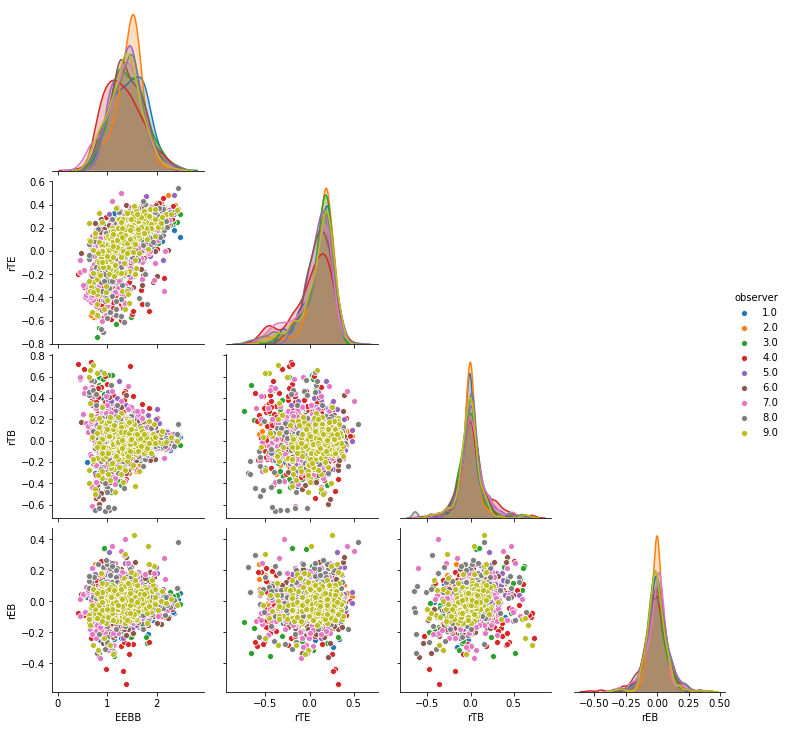

In [11]:
g = sns.pairplot(df.where((df.EEBB<2.5)),hue='observer',dropna=True,corner=True)
g.savefig('../figures/all_ratios_{}.png'.format(bcut),bbox_inches='tight',dpi=200)

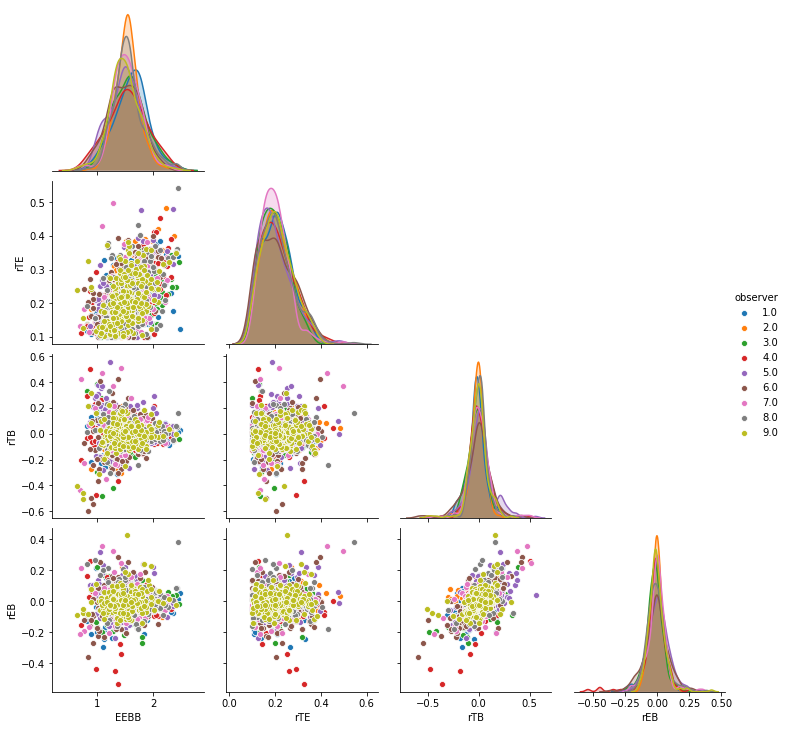

In [12]:
g=sns.pairplot(df.where((df.rTE>0.1) & (df.EEBB<2.5)),hue='observer',dropna=True,corner=True)
g.savefig('../figures/rTEp01_ratios_{}.png'.format(bcut),bbox_inches='tight',dpi=200)

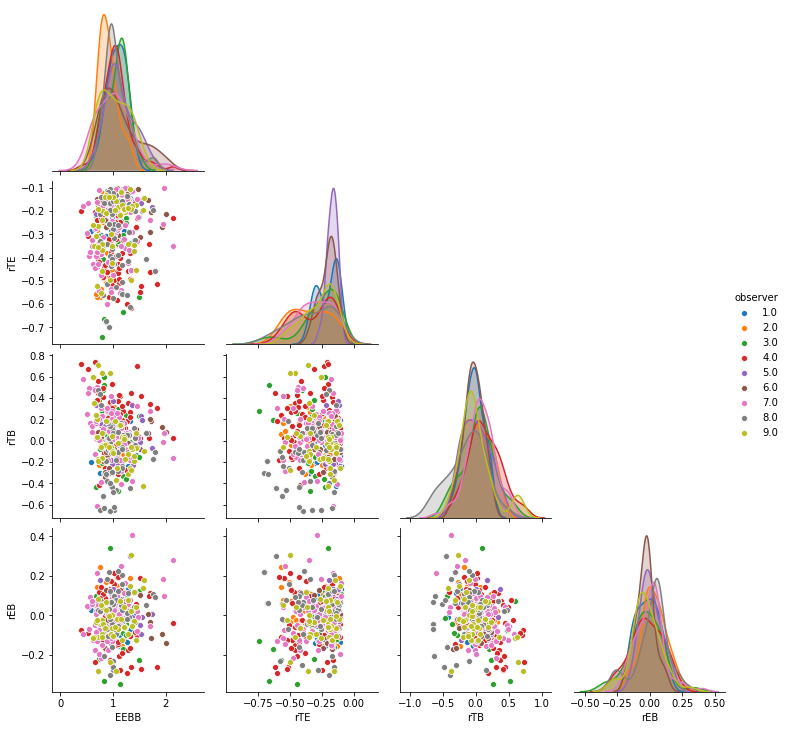

In [13]:
g=sns.pairplot(df.where((df.rTE<-0.1) & (df.EEBB<2.5)),hue='observer',dropna=True,corner=True)
g.savefig('../figures/rTEn01_ratios_{}.png'.format(bcut),bbox_inches='tight',dpi=200)

# distribution from all observers with correlation coefficient

In [80]:
labels_dict = dict(EEBB=r'$EE/BB$', rTE=r'$r^{TE}$', rTB=r'$r^{TB}$', rEB=r'$r^{EB}$',)
def pair_plot_with_corr(df_selected, labels = [r'$EE/BB$',r'$r^{TE}$',r'$r^{TB}$',r'$r^{EB}$'], corr_method='spearman'):
    g = sns.PairGrid(df_selected,diag_sharey=False,corner=True)
    g.map_lower(sns.scatterplot, s=15)
    g.map_diag(sns.distplot,kde=False)

    if labels is not None:
        for ax,lab in zip(g.axes[1:,0],labels[1:]):
            ax.set_ylabel(lab)
        for ax,lab in zip(g.axes[-1,:],labels[:]):
            ax.set_xlabel(lab)
        
    corr = df_selected.corr(method=corr_method)
    for i,xv in enumerate(g.x_vars):
        for j,yv in enumerate(g.y_vars[i+1:]):
            plt.sca(g.axes[j+i+1,i])
            plt.annotate(r'$\rho = {:.2f}$'.format(corr[xv][yv]),(0.95,0.05),
                         ha='right',va='bottom',xycoords='axes fraction',
                         path_effects=[withStroke(foreground='w',linewidth=3)]
                        )
            print(xv,yv,corr[xv][yv])
        plt.sca(g.axes[i,i])
        q=df_selected[xv].quantile([0.16,0.5,0.84])
        dql=(q[0.16]-q[0.5])
        dqu=(q[0.84]-q[0.5])
        plt.title(labels_dict[xv]+r'$ = {:.2f}^{{{:.2f}}}_{{{:.2f}}}$'.format(q[0.5],dqu,dql))
    for i,xv in enumerate(g.x_vars):
        plt.sca(g.axes[-1,i])
        if (xv == 'EEBB'): plt.xlim(0,3)
        elif (xv == 'rTE'): plt.xlim(-0.55,0.55)
        elif (xv == 'rTB'): plt.xlim(-0.55,0.55)
        elif (xv == 'rEB'): plt.xlim(-0.55,0.55)
    for i,yv in enumerate(g.y_vars[1:]):
        plt.sca(g.axes[i+1,0])
        if (yv == 'EEBB'): plt.ylim(0,3)
        elif (yv == 'rTE'): plt.ylim(-0.55,0.55)
        elif (yv == 'rTB'): plt.ylim(-0.55,0.55)
        elif (yv == 'rEB'): plt.ylim(-0.55,0.55)
    return g

EEBB rTE 0.5656994089946147
EEBB rTB -0.06604475280432204
EEBB rEB 0.0484571314136656
rTE rTB -0.06266199327675549
rTE rEB 0.030645788819743433
rTB rEB 0.22784150157265295
EEBB rTE 0.6273540288398642
EEBB rTB -0.023540052810908874
EEBB rEB 0.03039332982164118
rTE rTB -0.02334896385237131
rTE rEB 0.01130642497179294
rTB rEB 0.2731036351494383
EEBB rTE 0.45098055820189825
EEBB rTB -0.012303427139883158
EEBB rEB 0.022223431978909906
rTE rTB -0.014867708065548647
rTE rEB 0.00808661857883833
rTB rEB 0.1972171563660925


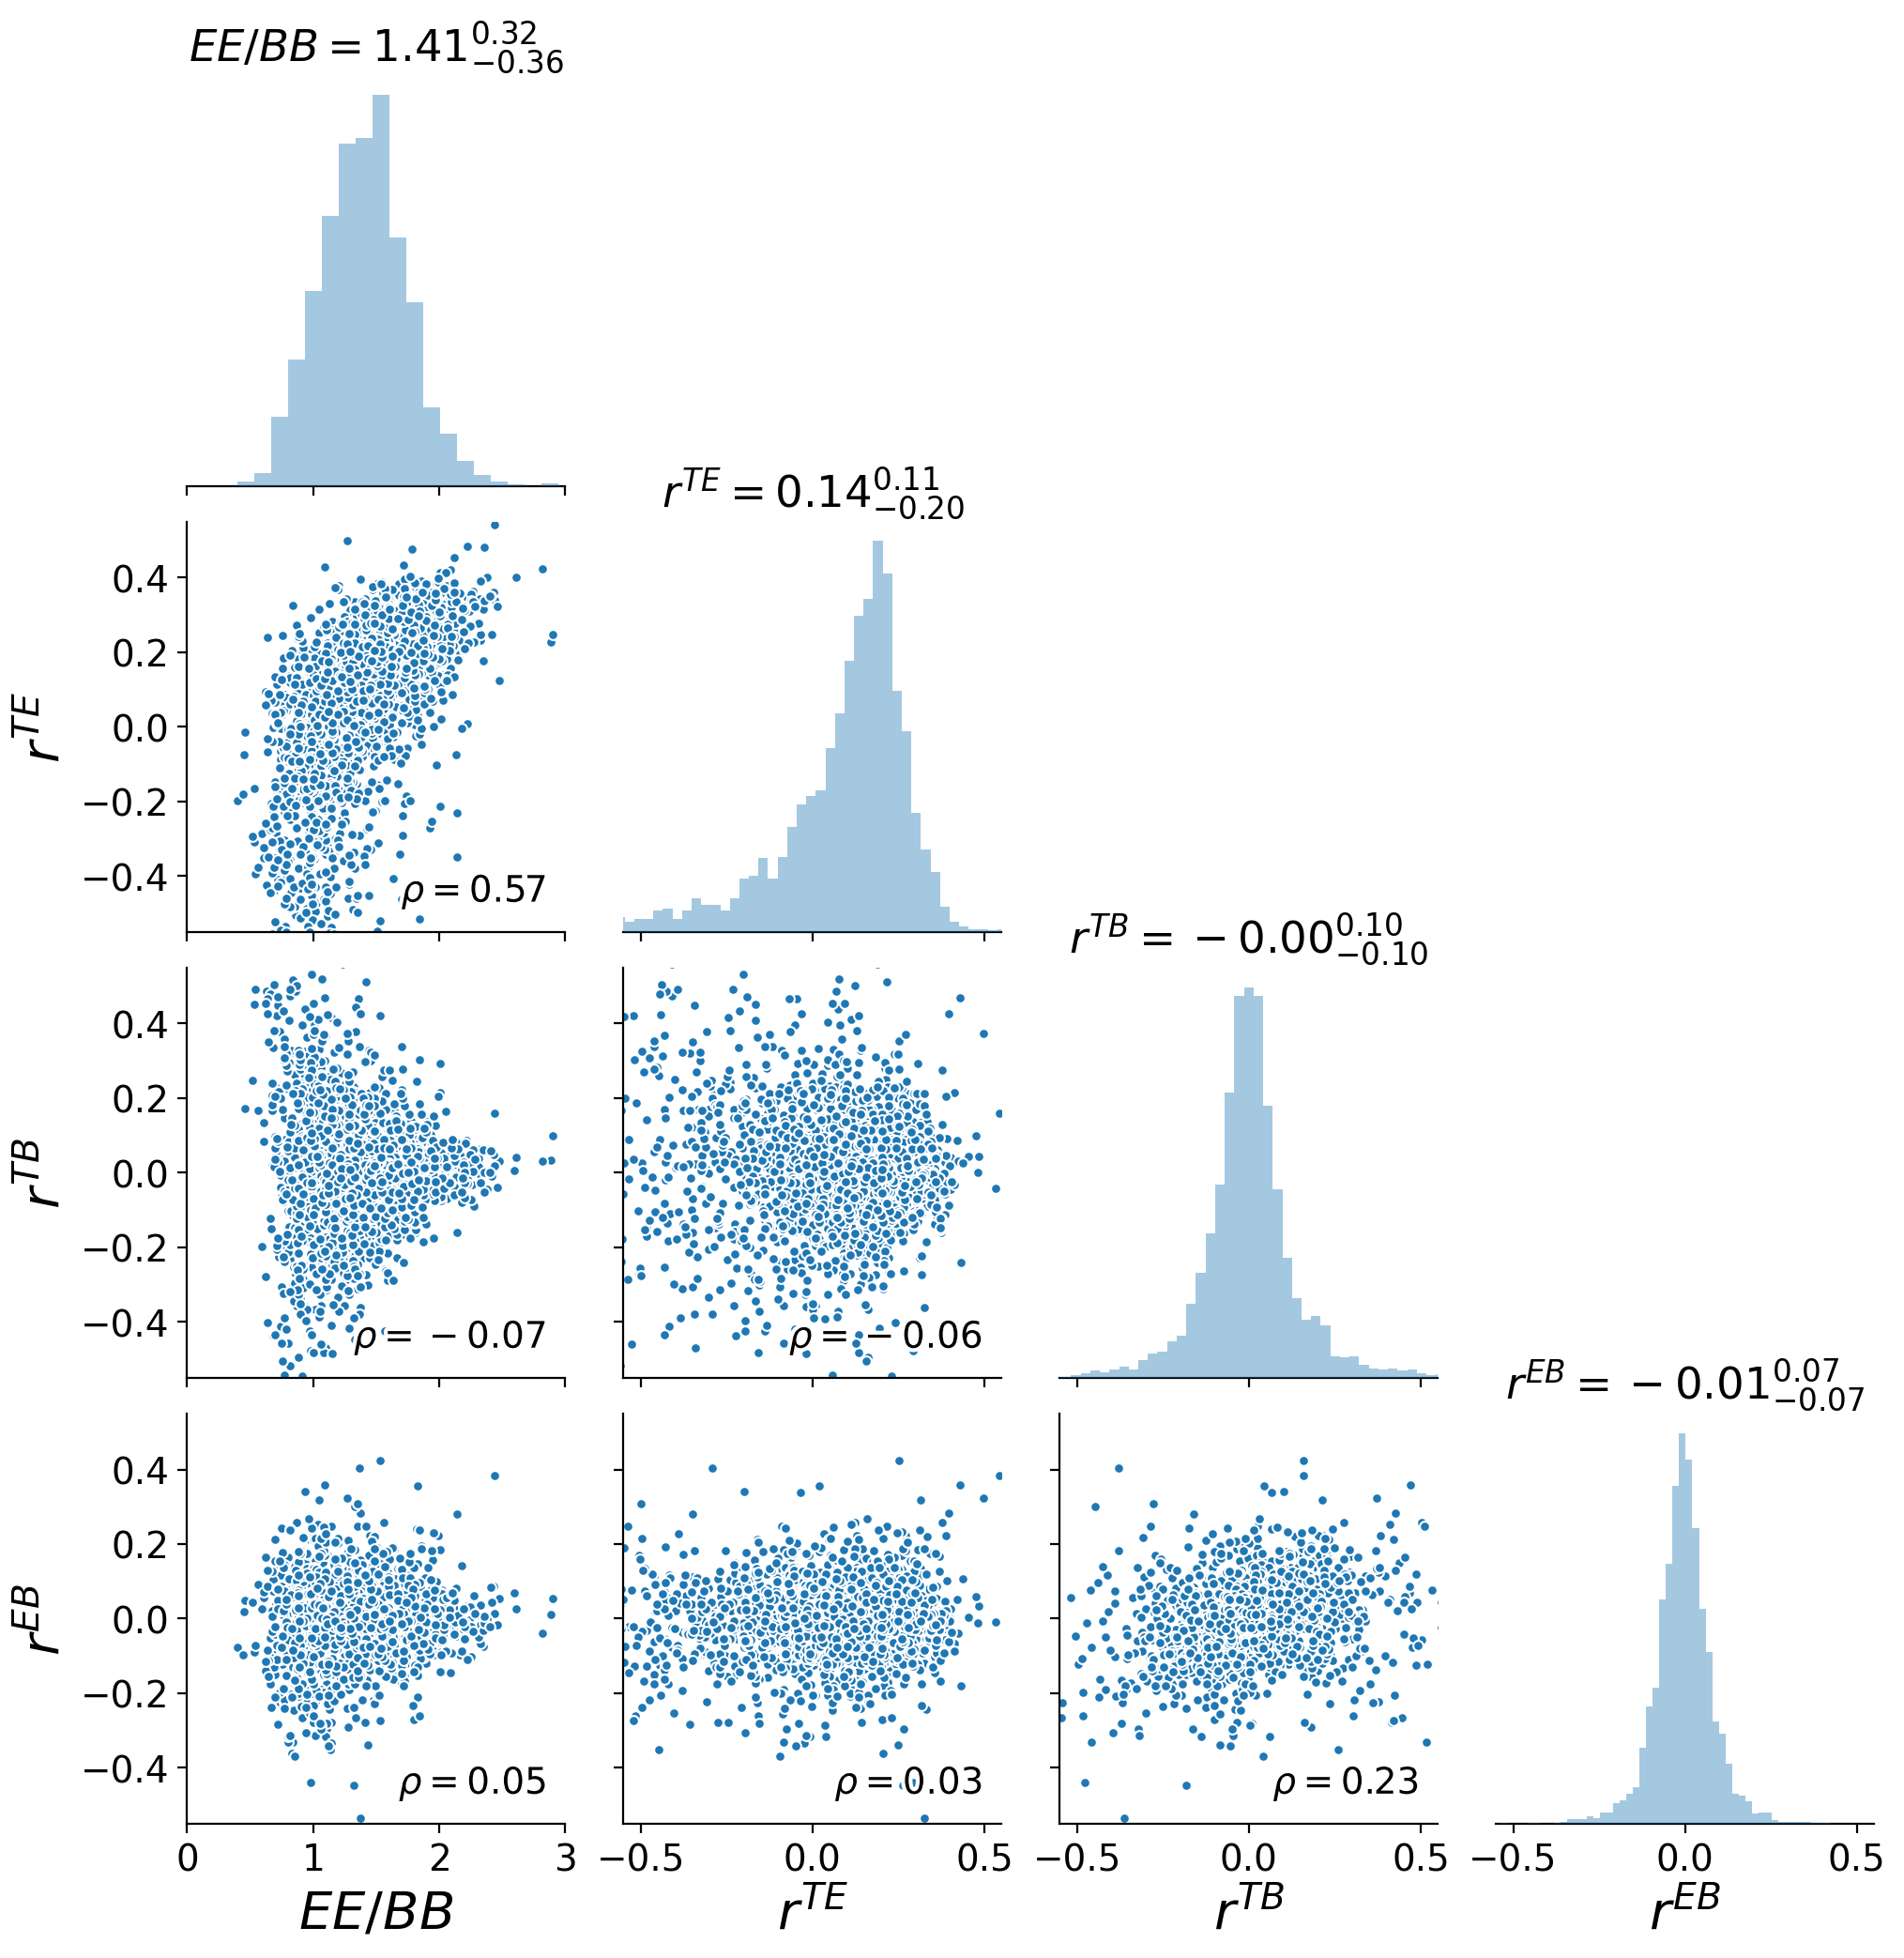

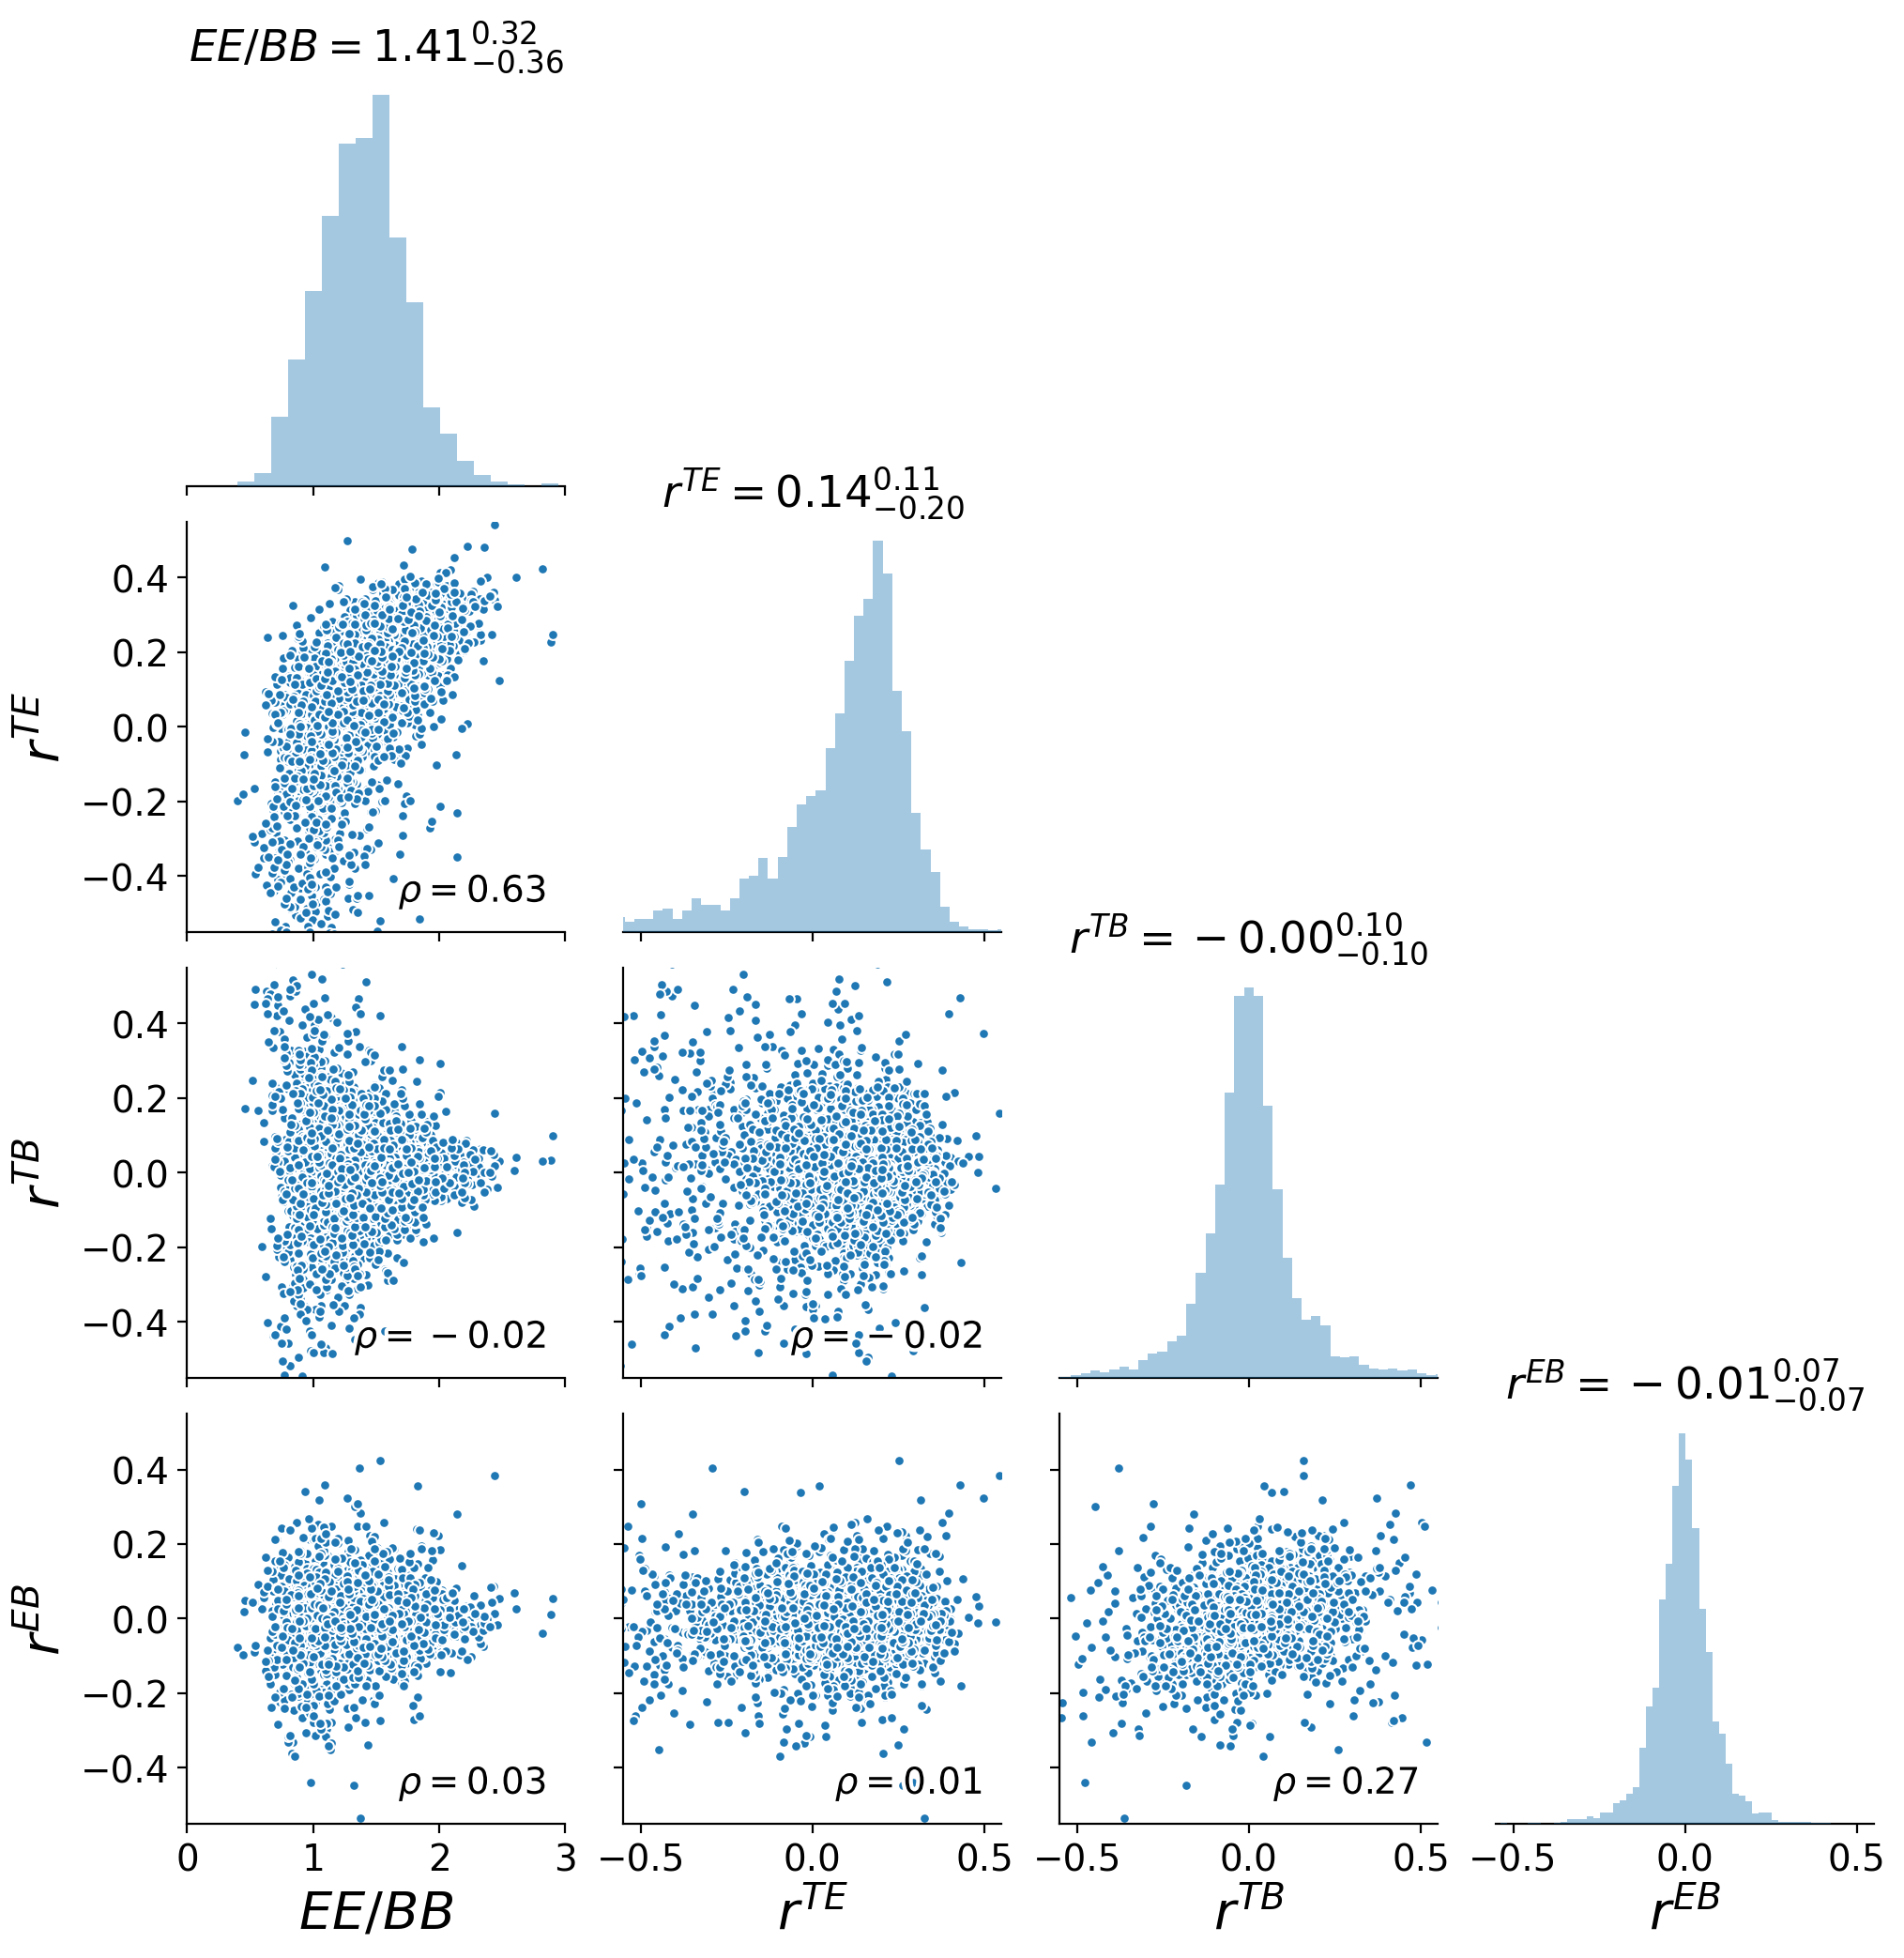

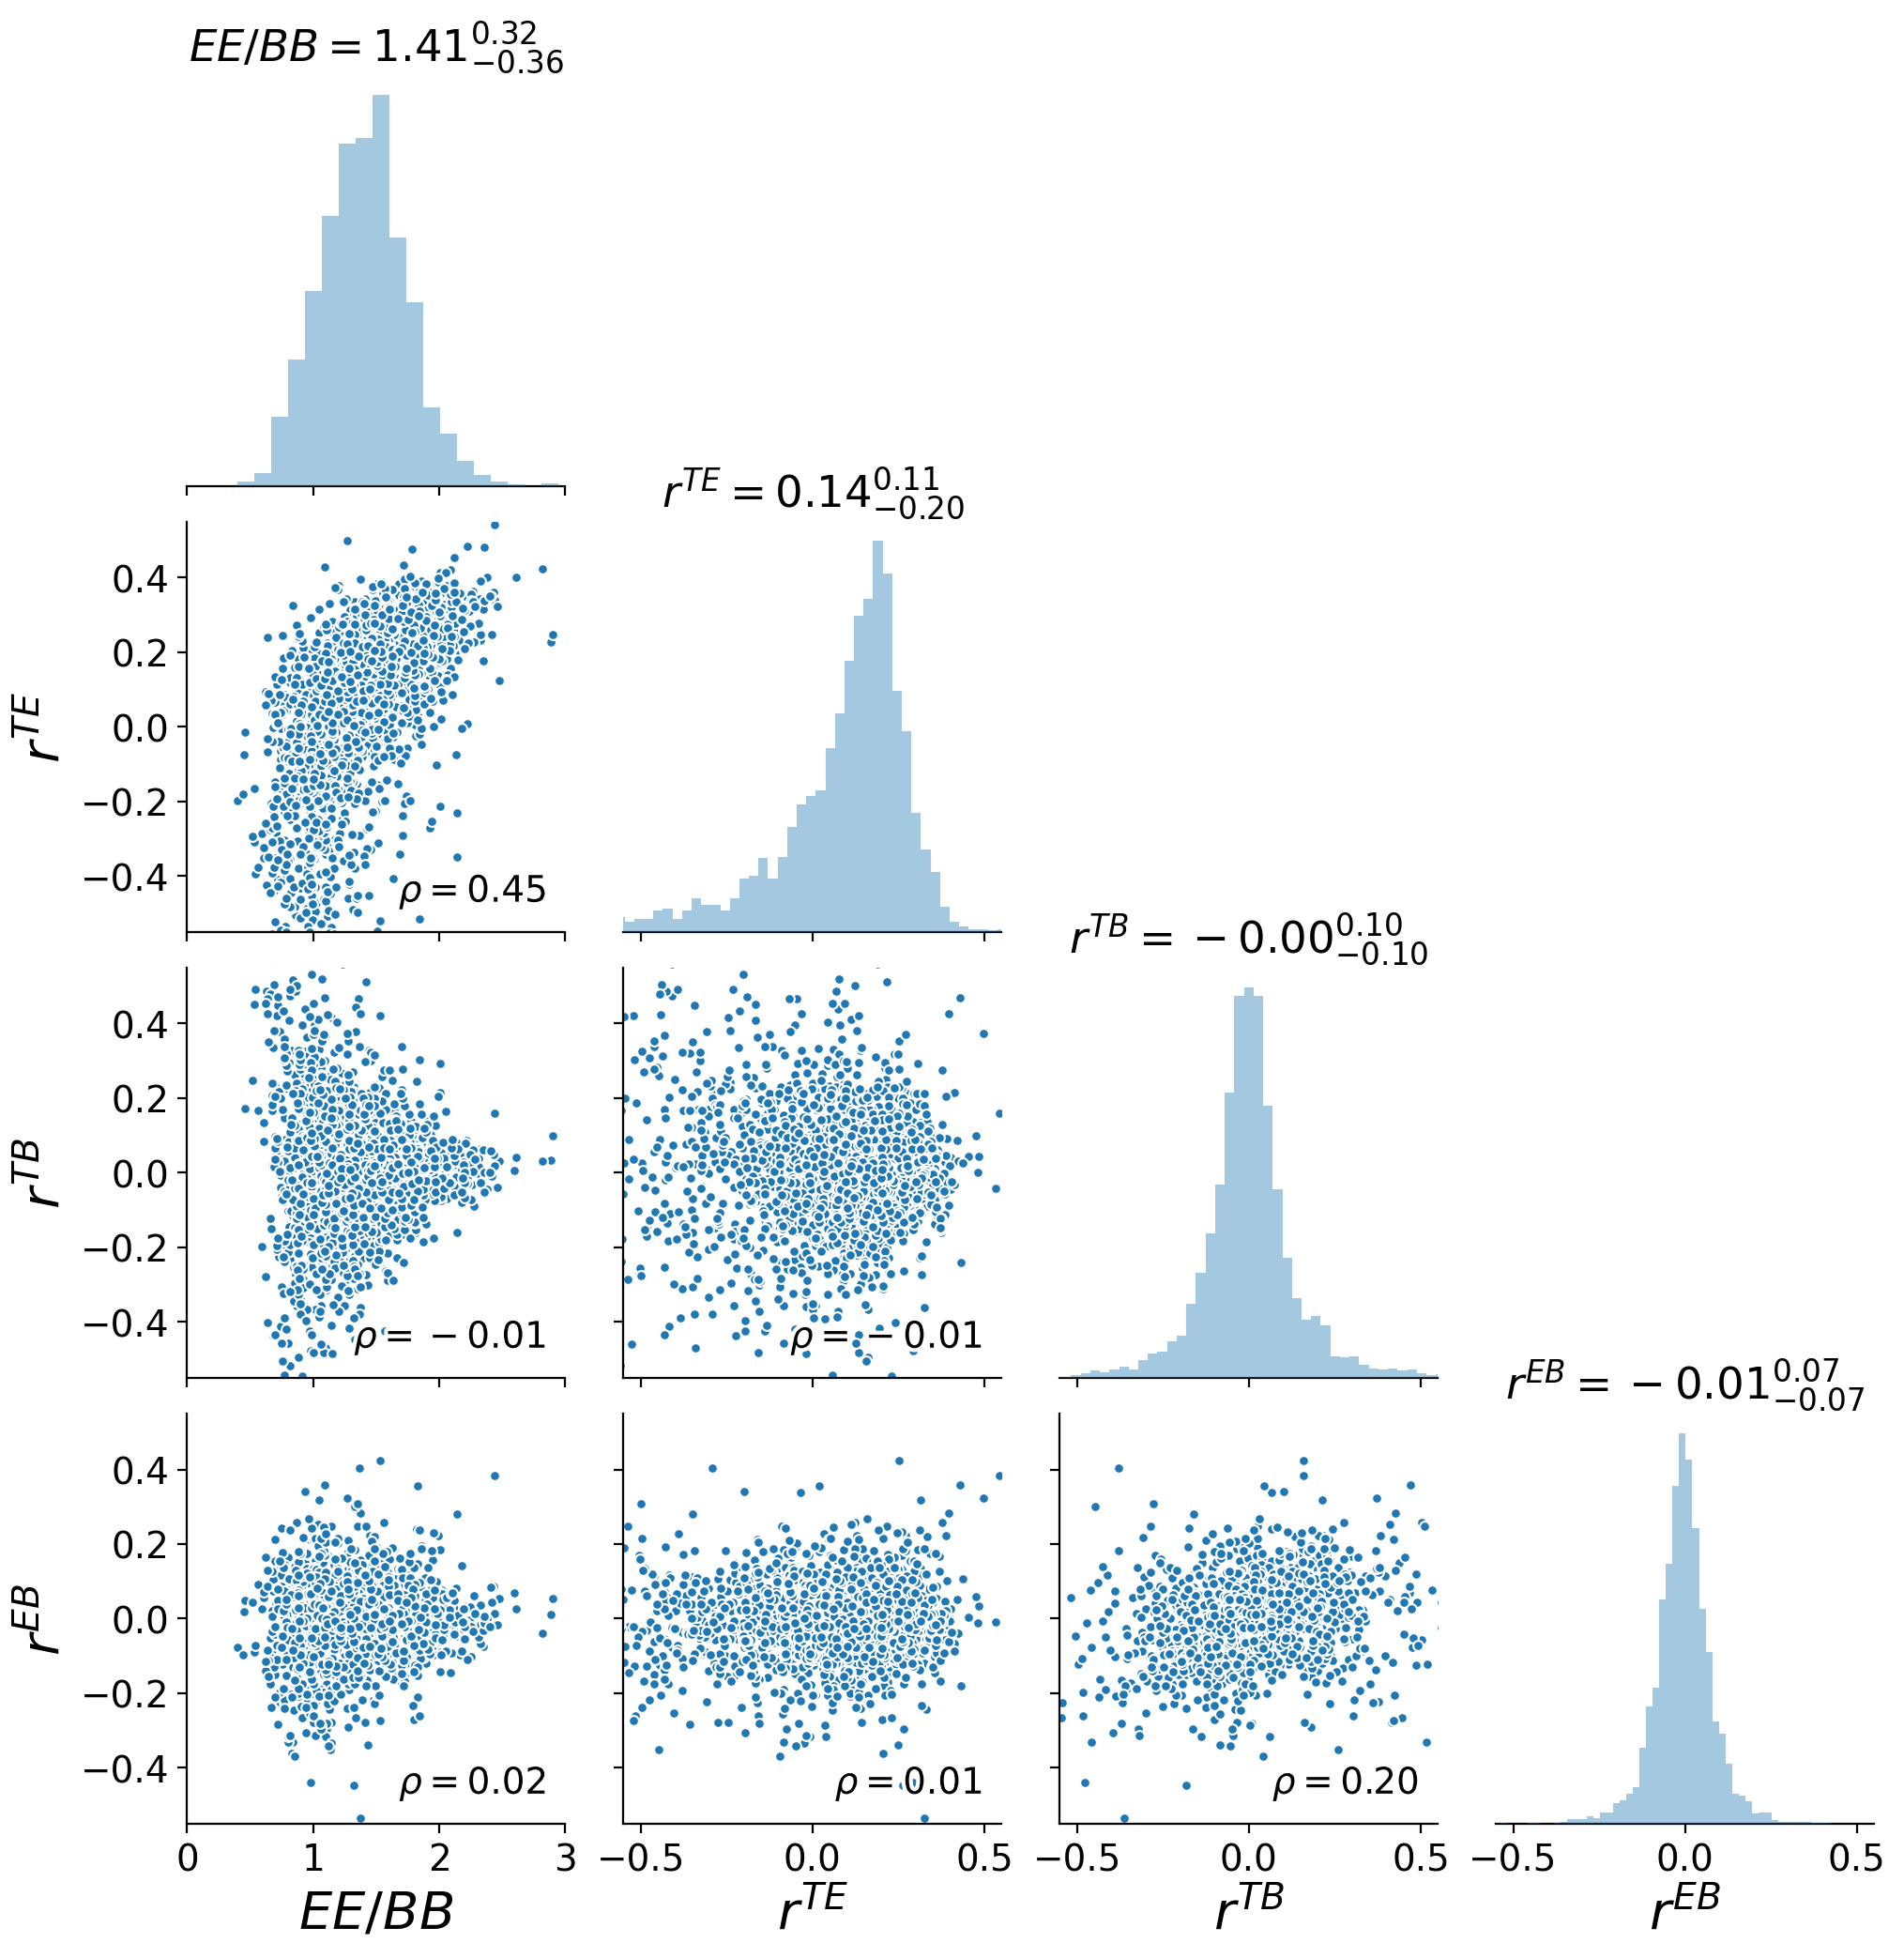

In [81]:
with plt.style.context({'figure.dpi':200,'font.size':14,'axes.labelsize':'x-large'}):
    df_selected = df[['EEBB','rTE','rTB','rEB']]
    for corr_method in ['pearson','spearman','kendall']:
        g = pair_plot_with_corr(df_selected,corr_method=corr_method)
        g.savefig('../figures/all_corr_{}_{}.png'.format(corr_method,bcut),bbox_inches='tight',dpi=200)

## rTE>0.1: rTB and rEB are correlated

EEBB rTE 0.45433932778323016
EEBB rTB 0.02786124795833873
EEBB rEB 0.045295832911295686
rTE rTB 0.04155453341290527
rTE rEB 0.0520965787075865
rTB rEB 0.5398367611469105


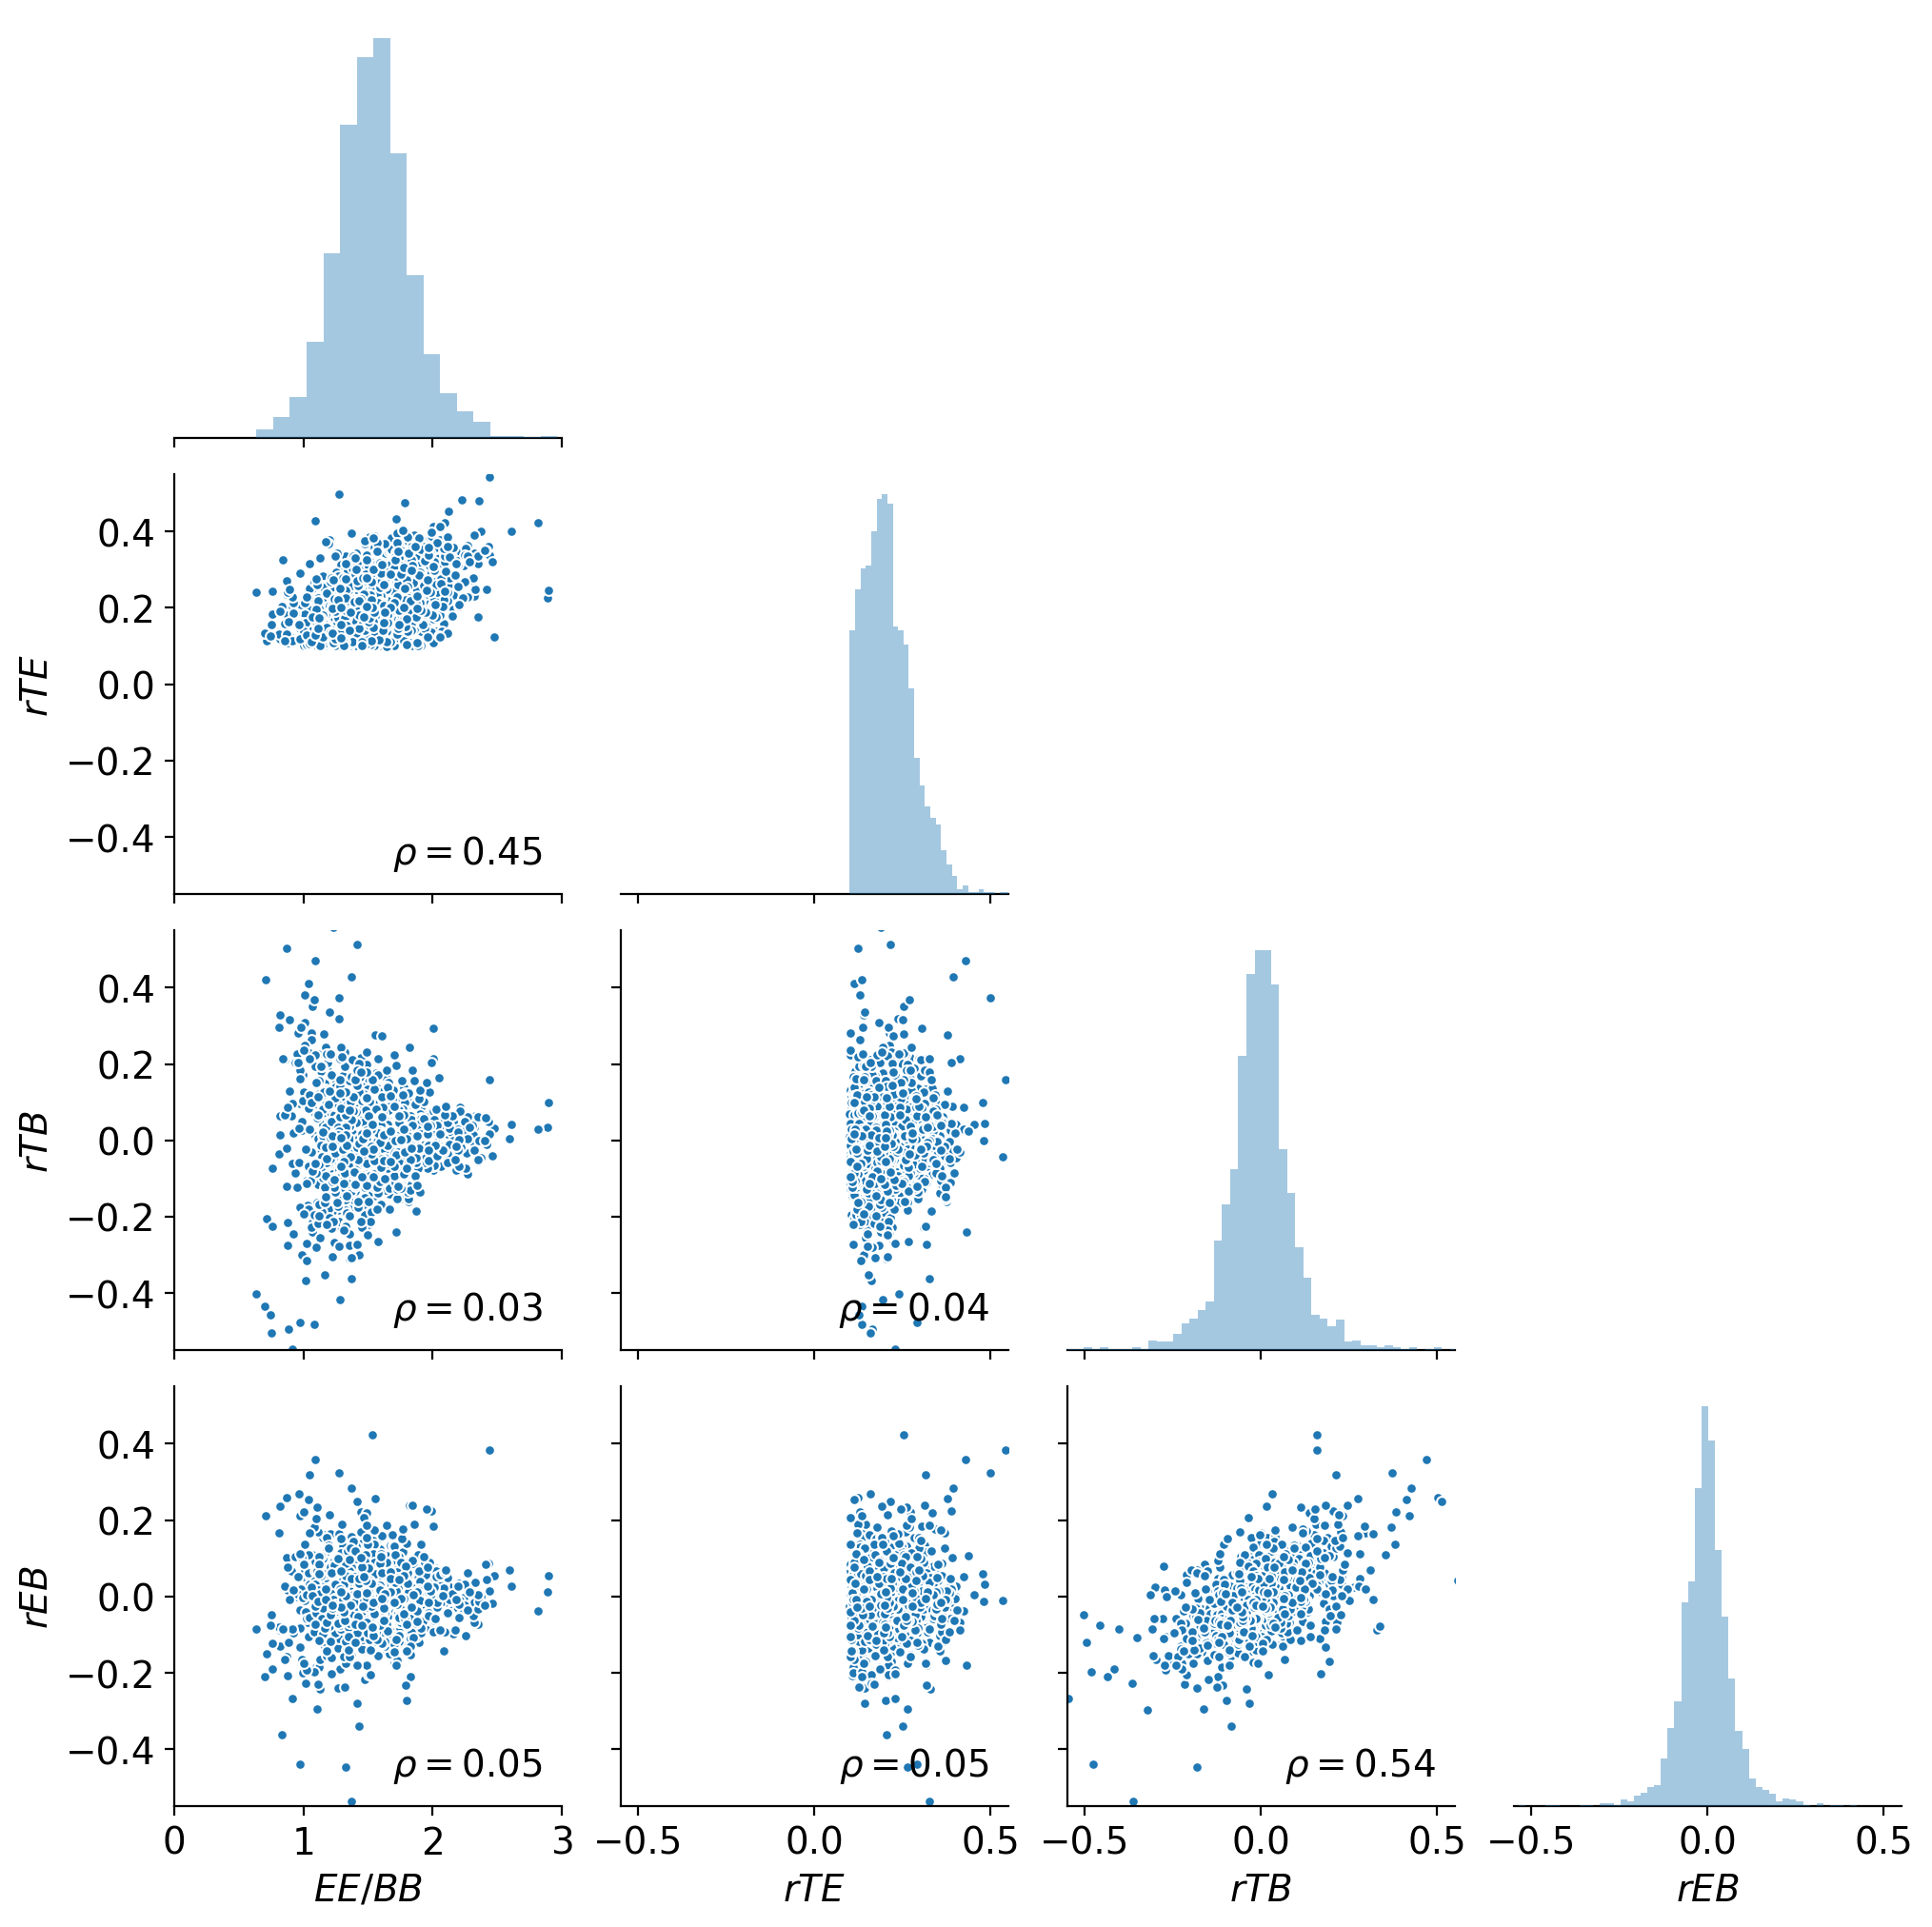

In [14]:
with plt.style.context({'figure.dpi':200,'font.size':14}):
    df_selected = df[['EEBB','rTE','rTB','rEB']].where((df.rTE>0.1))
    g = pair_plot_with_corr(df_selected)
    g.savefig('../figures/rTEp01_all_{}.png'.format(bcut),bbox_inches='tight',dpi=200)

## rTE<-0.1: rTB and rEB are anti-correlated

EEBB rTE 0.10478339217233693
EEBB rTB -0.12038003913346984
EEBB rEB 0.0970912020807875
rTE rTB -0.05907299057658472
rTE rEB 0.06034820483409119
rTB rEB -0.29076769100197103


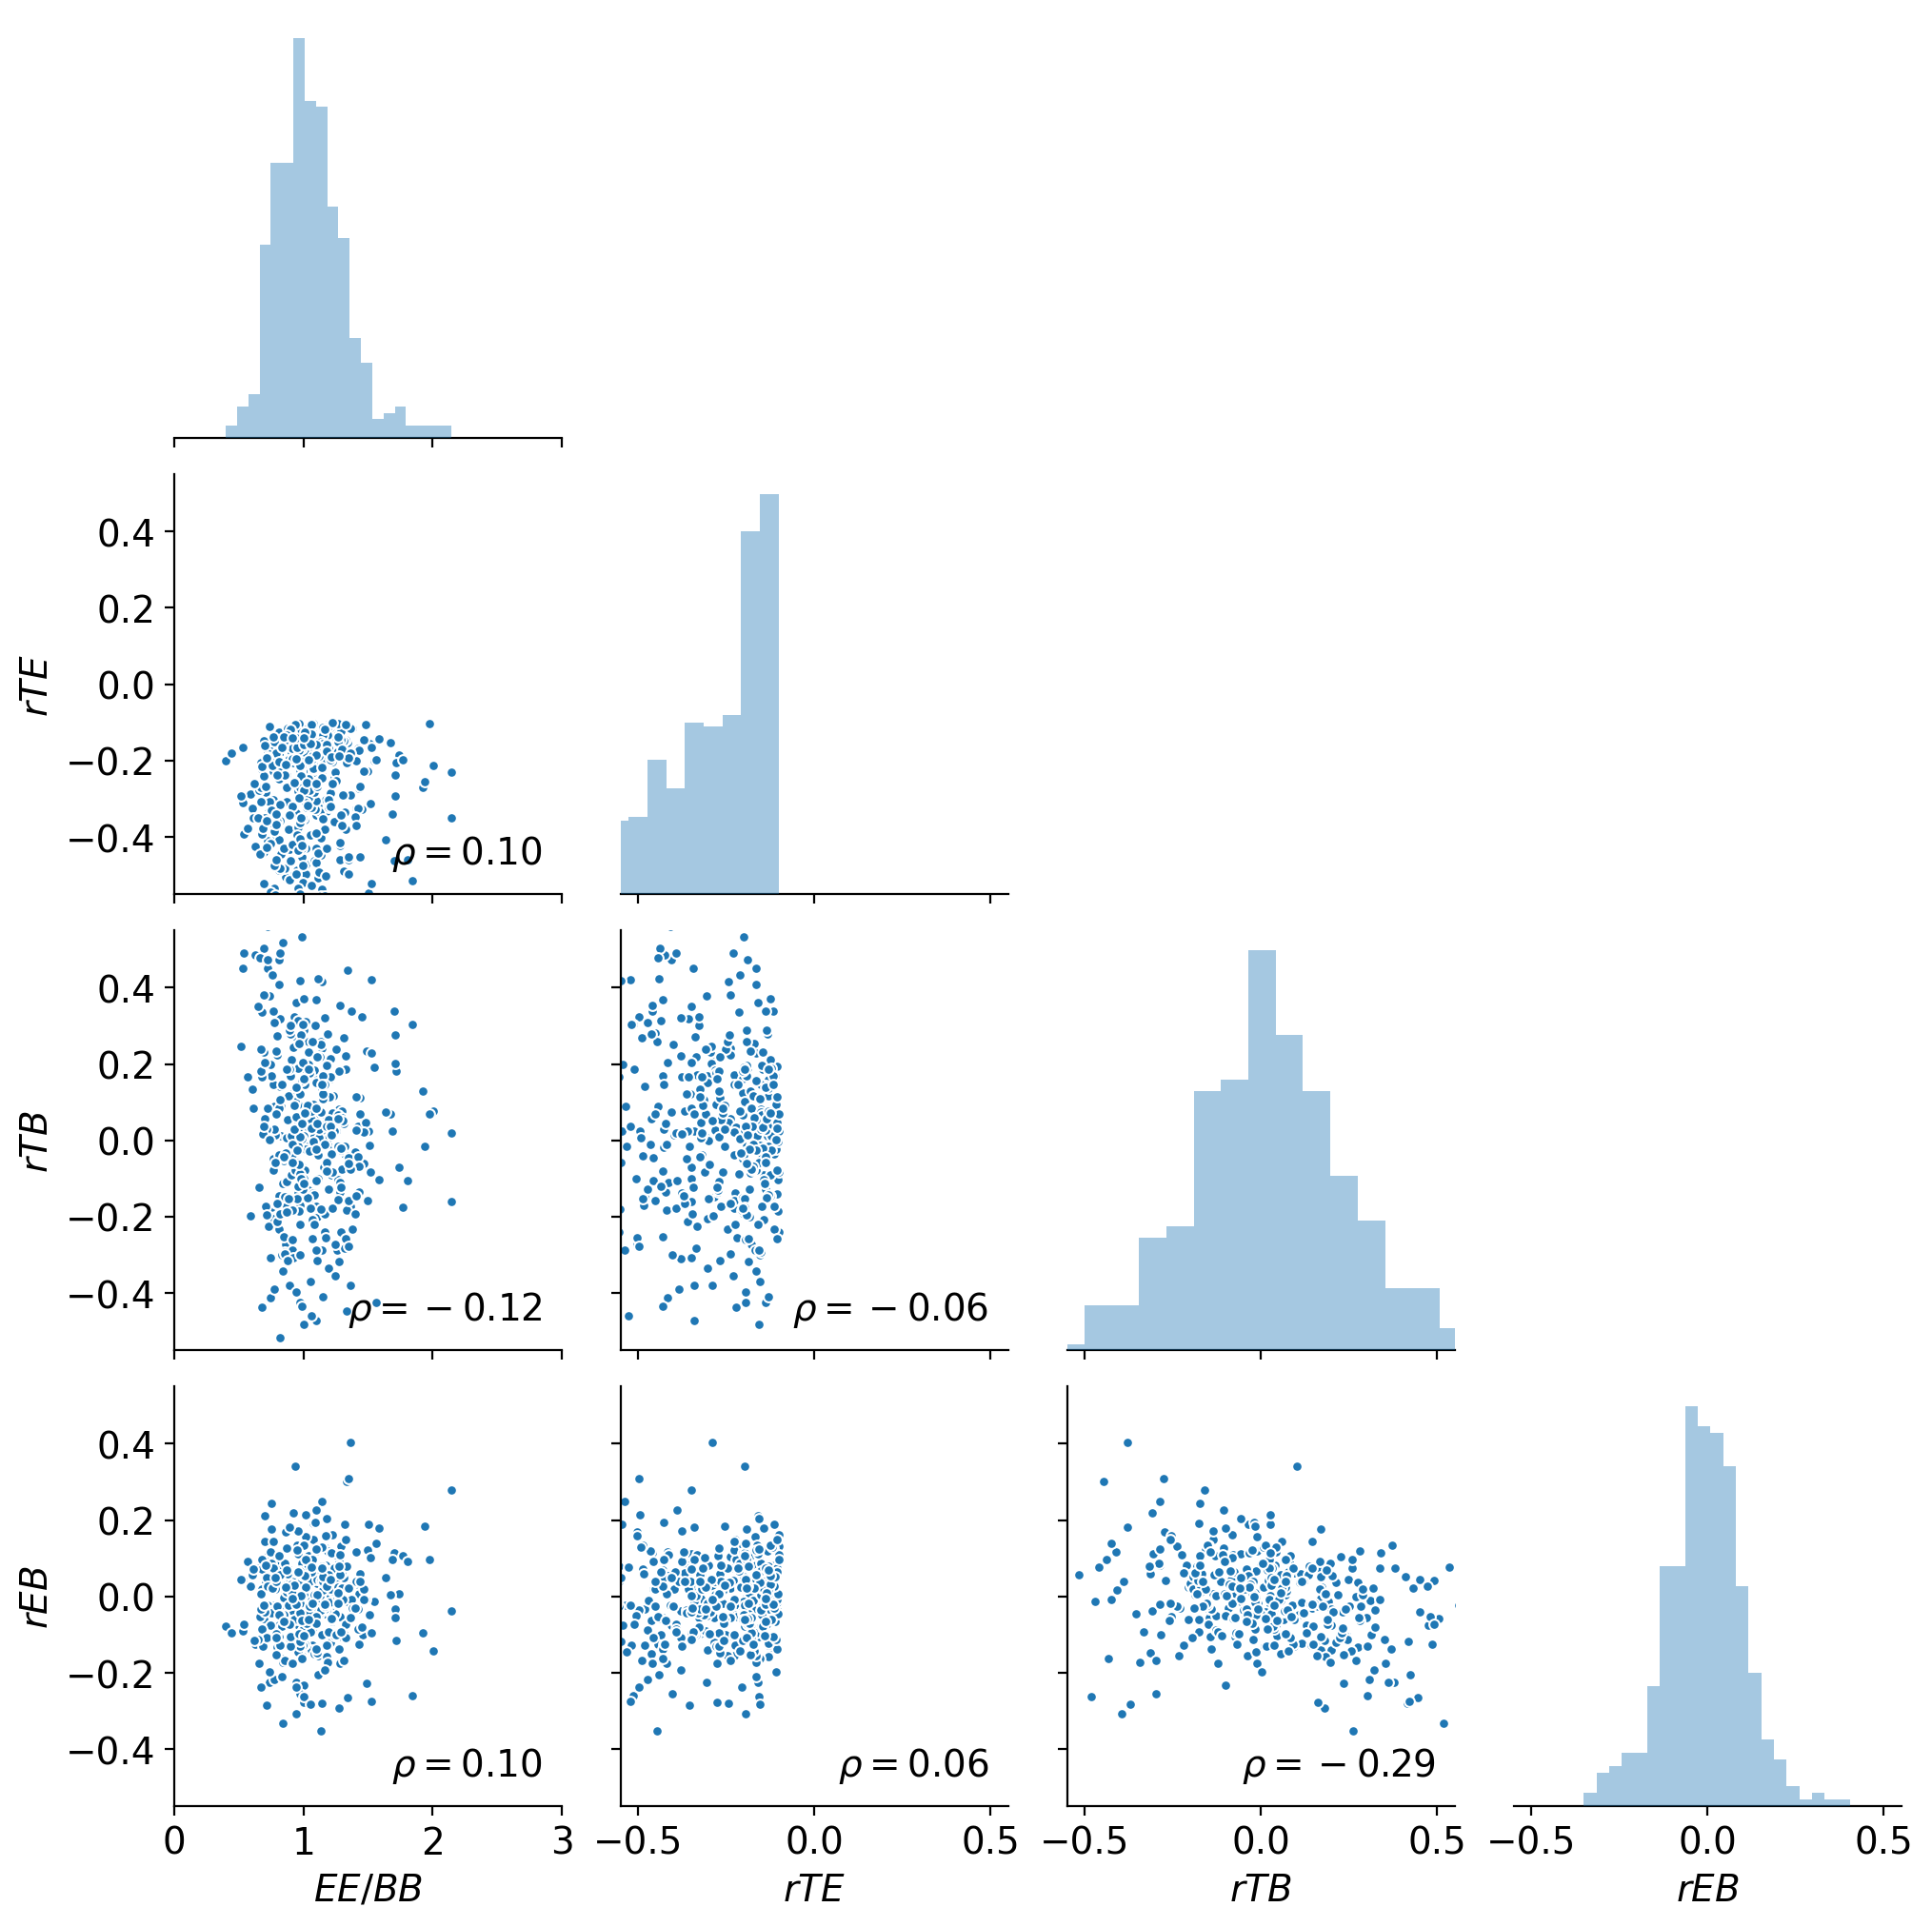

In [15]:
with plt.style.context({'figure.dpi':200,'font.size':14}):
    df_selected = df[['EEBB','rTE','rTB','rEB']].where((df.rTE<-0.1))
    g = pair_plot_with_corr(df_selected)
    g.savefig('../figures/rTEn01_all_{}.png'.format(bcut),bbox_inches='tight',dpi=200)

## rTB>0.1: rTE and rEB are correlated

EEBB rTE 0.4585778851184807
EEBB rTB -0.44945891692721174
EEBB rEB 0.16377751037332894
rTE rTB -0.3156733671381702
rTE rEB 0.5270300442277476
rTB rEB -0.10350686981068713


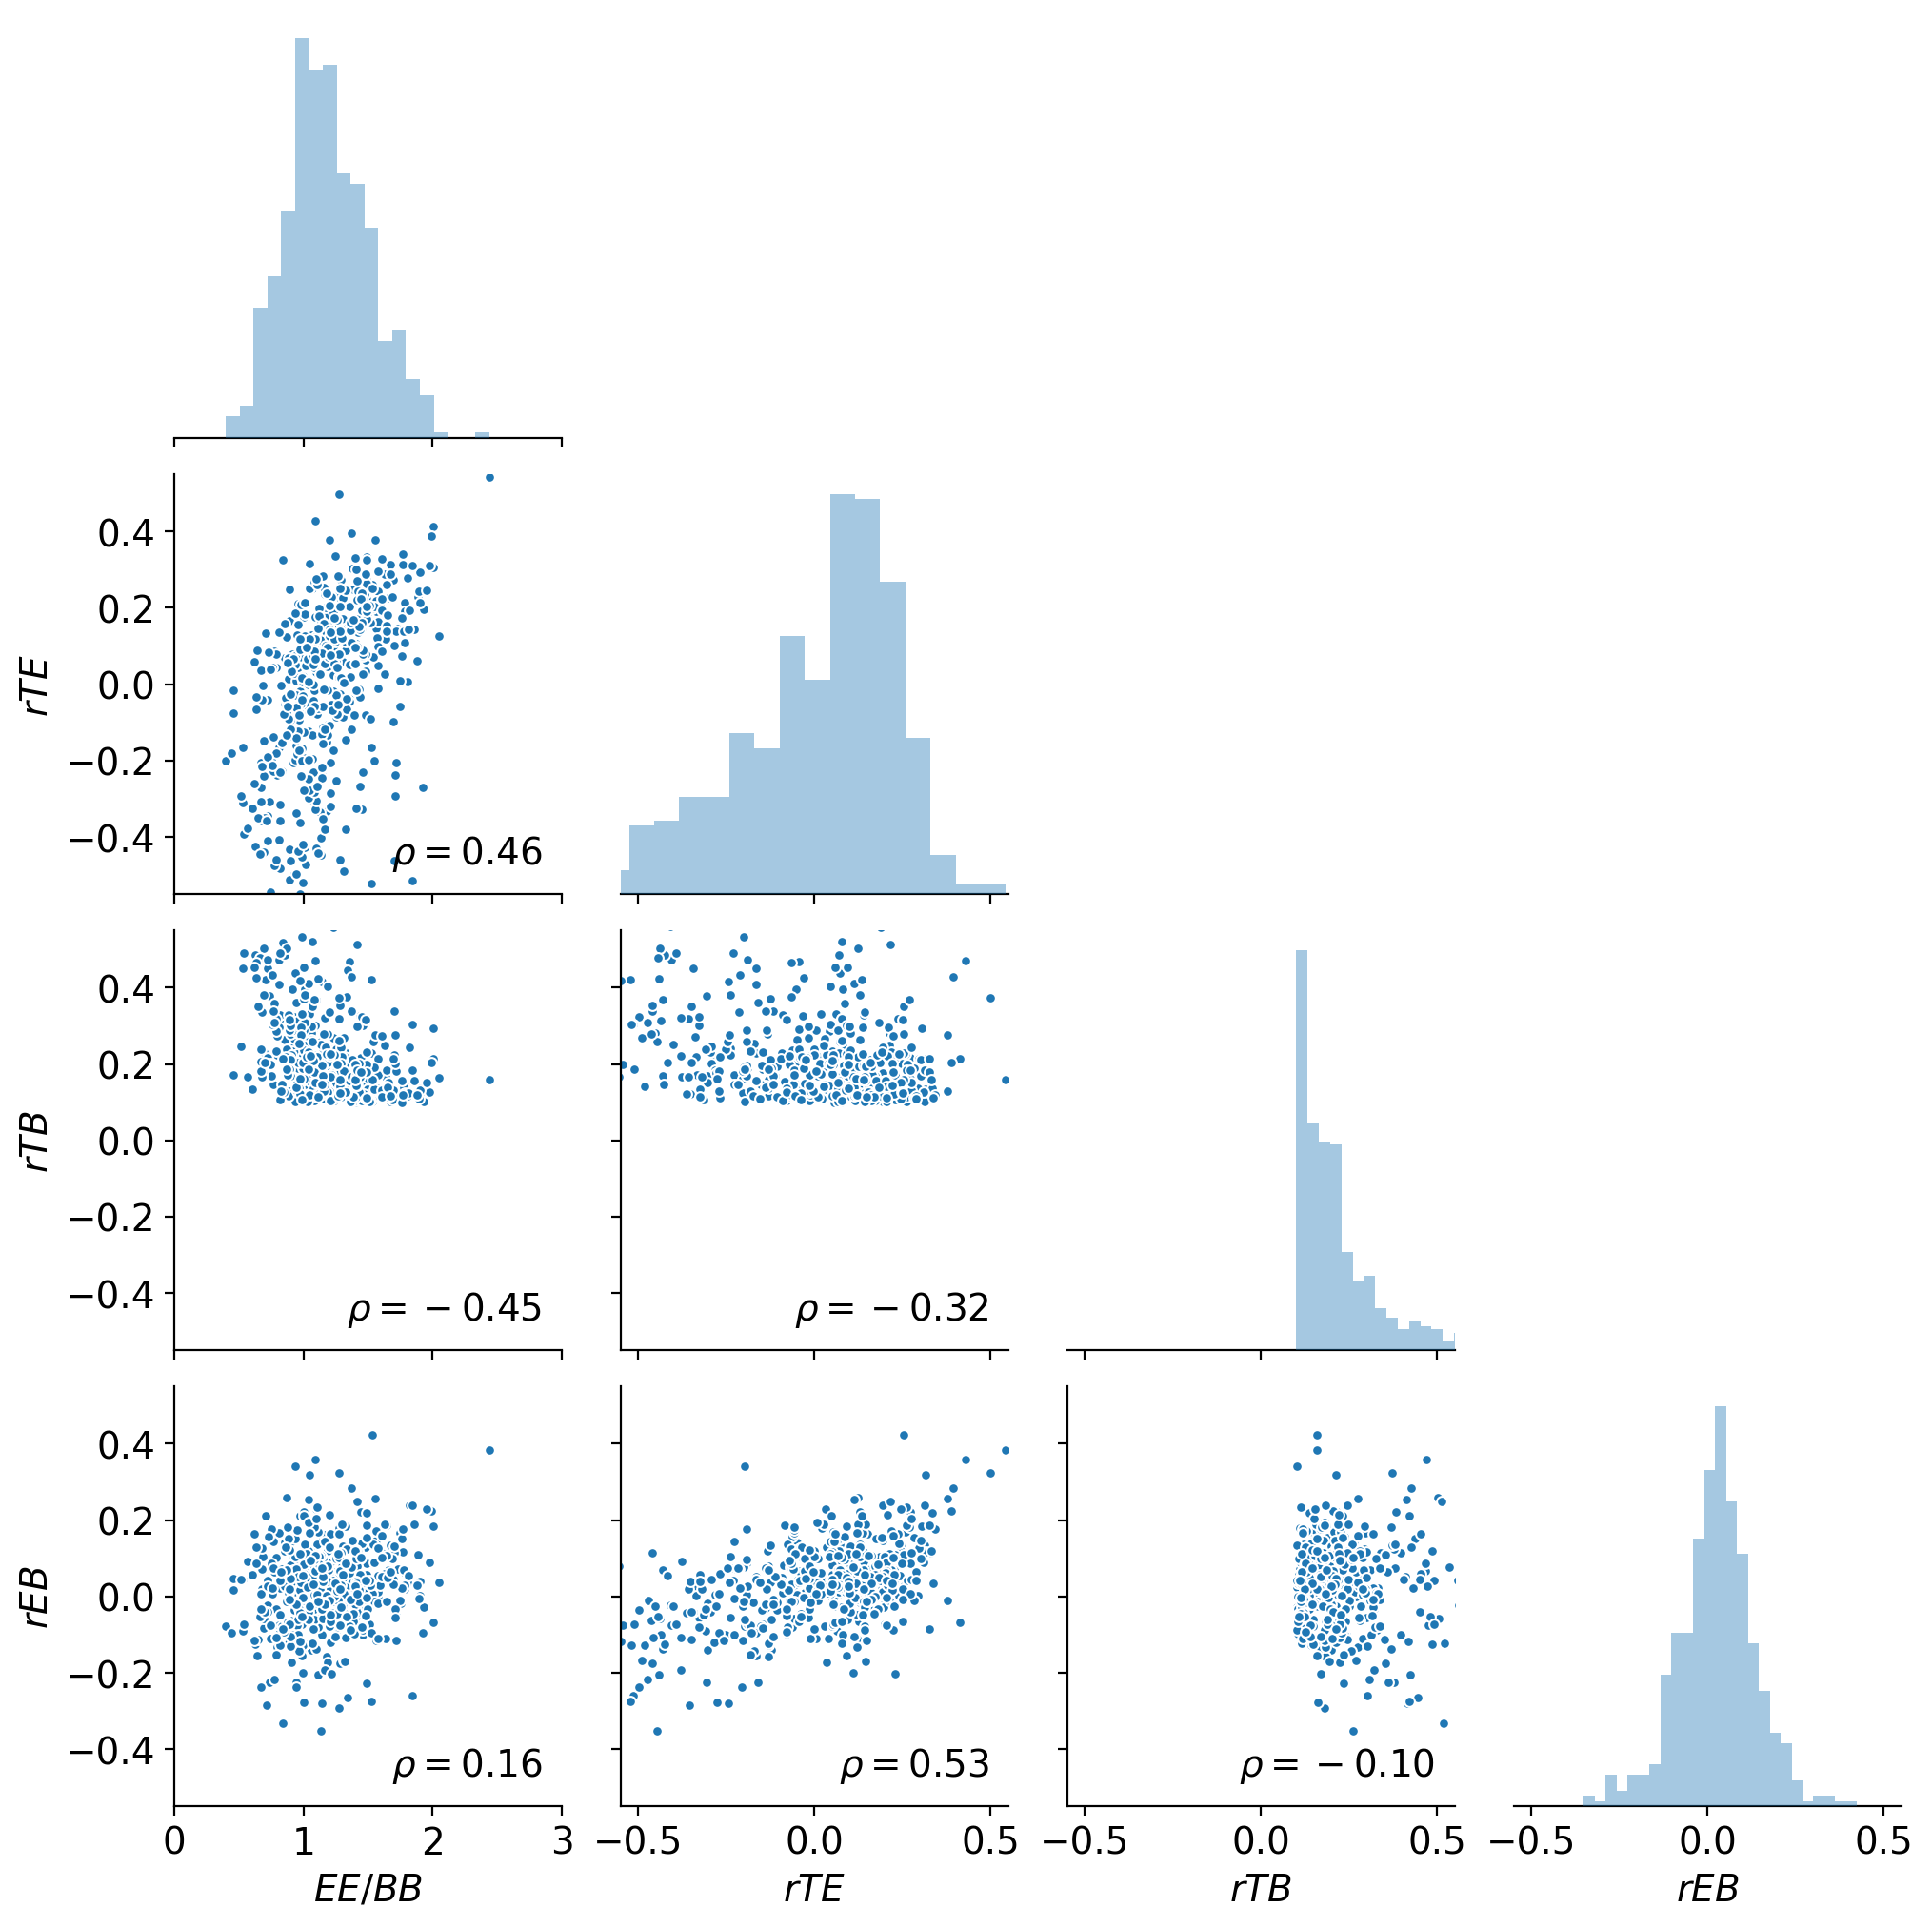

In [16]:
with plt.style.context({'figure.dpi':200,'font.size':14}):
    df_selected = df[['EEBB','rTE','rTB','rEB']].where((df.rTB>0.1))
    g = pair_plot_with_corr(df_selected)
    g.savefig('../figures/rTBp01_all_{}.png'.format(bcut),bbox_inches='tight',dpi=200)

## rTB<-0.1: rTE and rEB are anti-correlated

EEBB rTE 0.46837944635982504
EEBB rTB 0.36917142377416595
EEBB rEB 0.010752362759050123
rTE rTB 0.26008977548697515
rTE rEB -0.38728313115266183
rTB rEB 0.14271111519795684


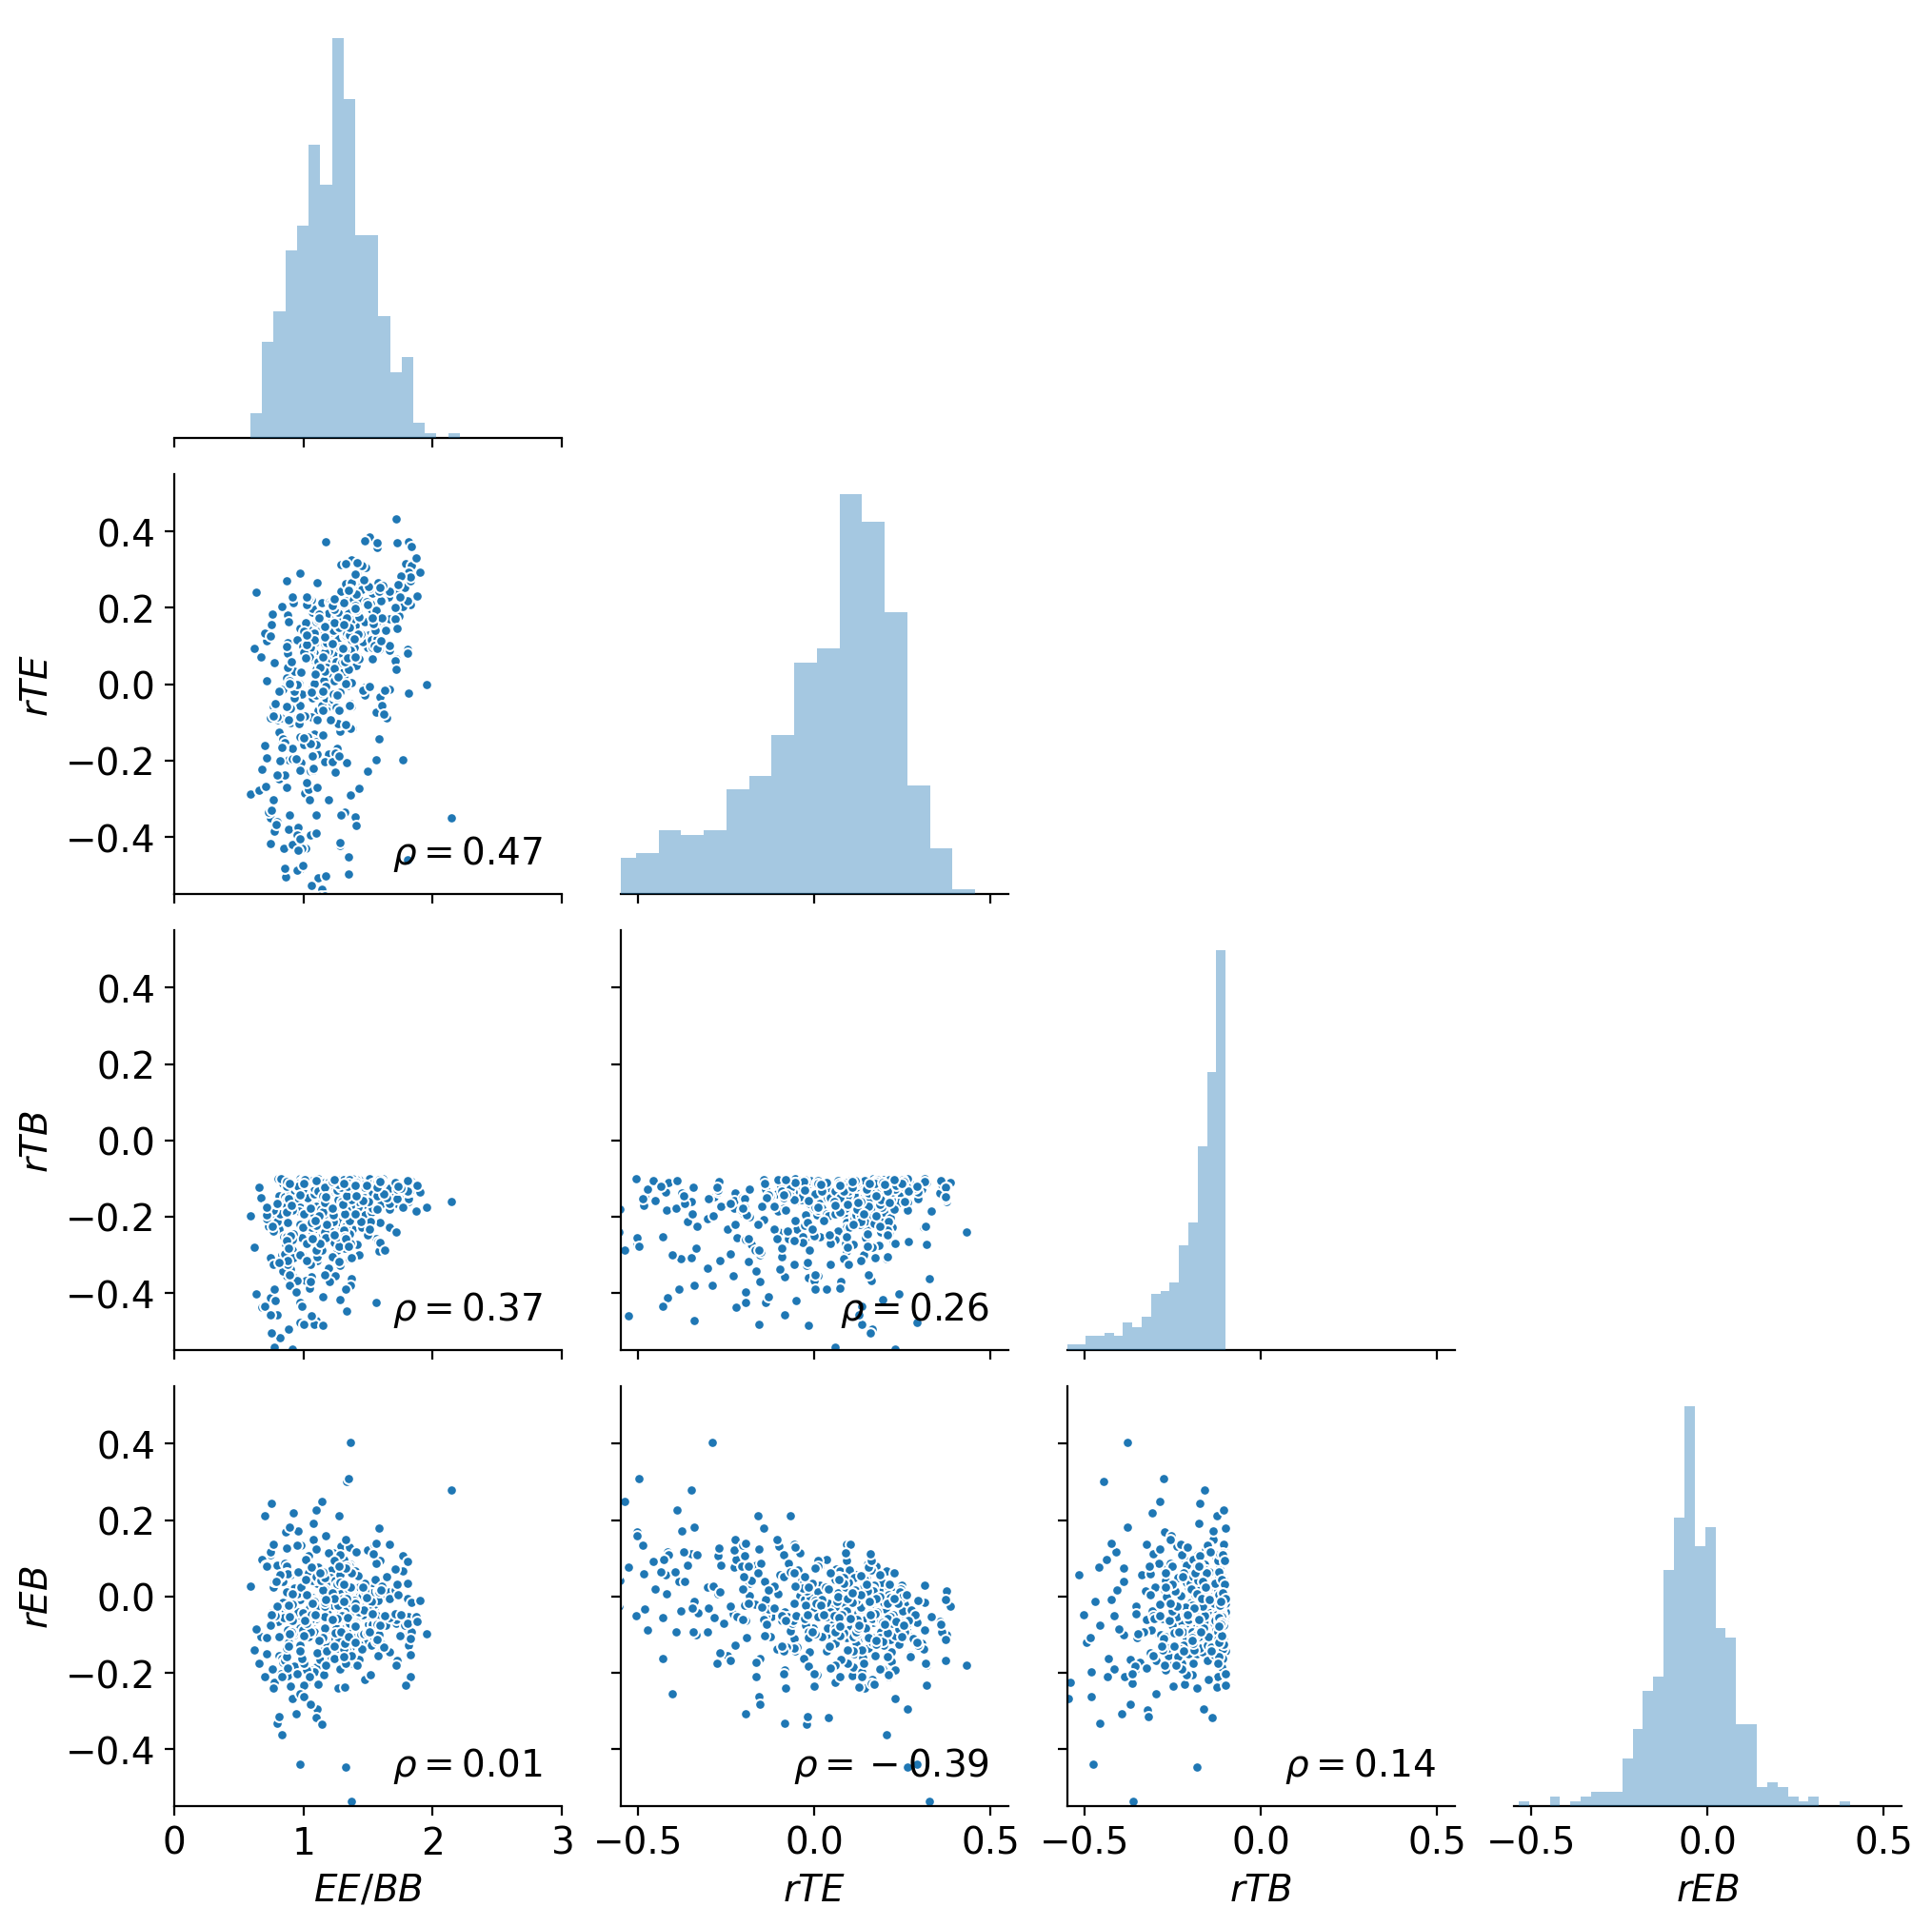

In [17]:
with plt.style.context({'figure.dpi':200,'font.size':14}):
    df_selected = df[['EEBB','rTE','rTB','rEB']].where((df.rTB<-0.1))
    g = pair_plot_with_corr(df_selected)
    g.savefig('../figures/rTBn01_all_{}.png'.format(bcut),bbox_inches='tight',dpi=200)

# Summary plots 

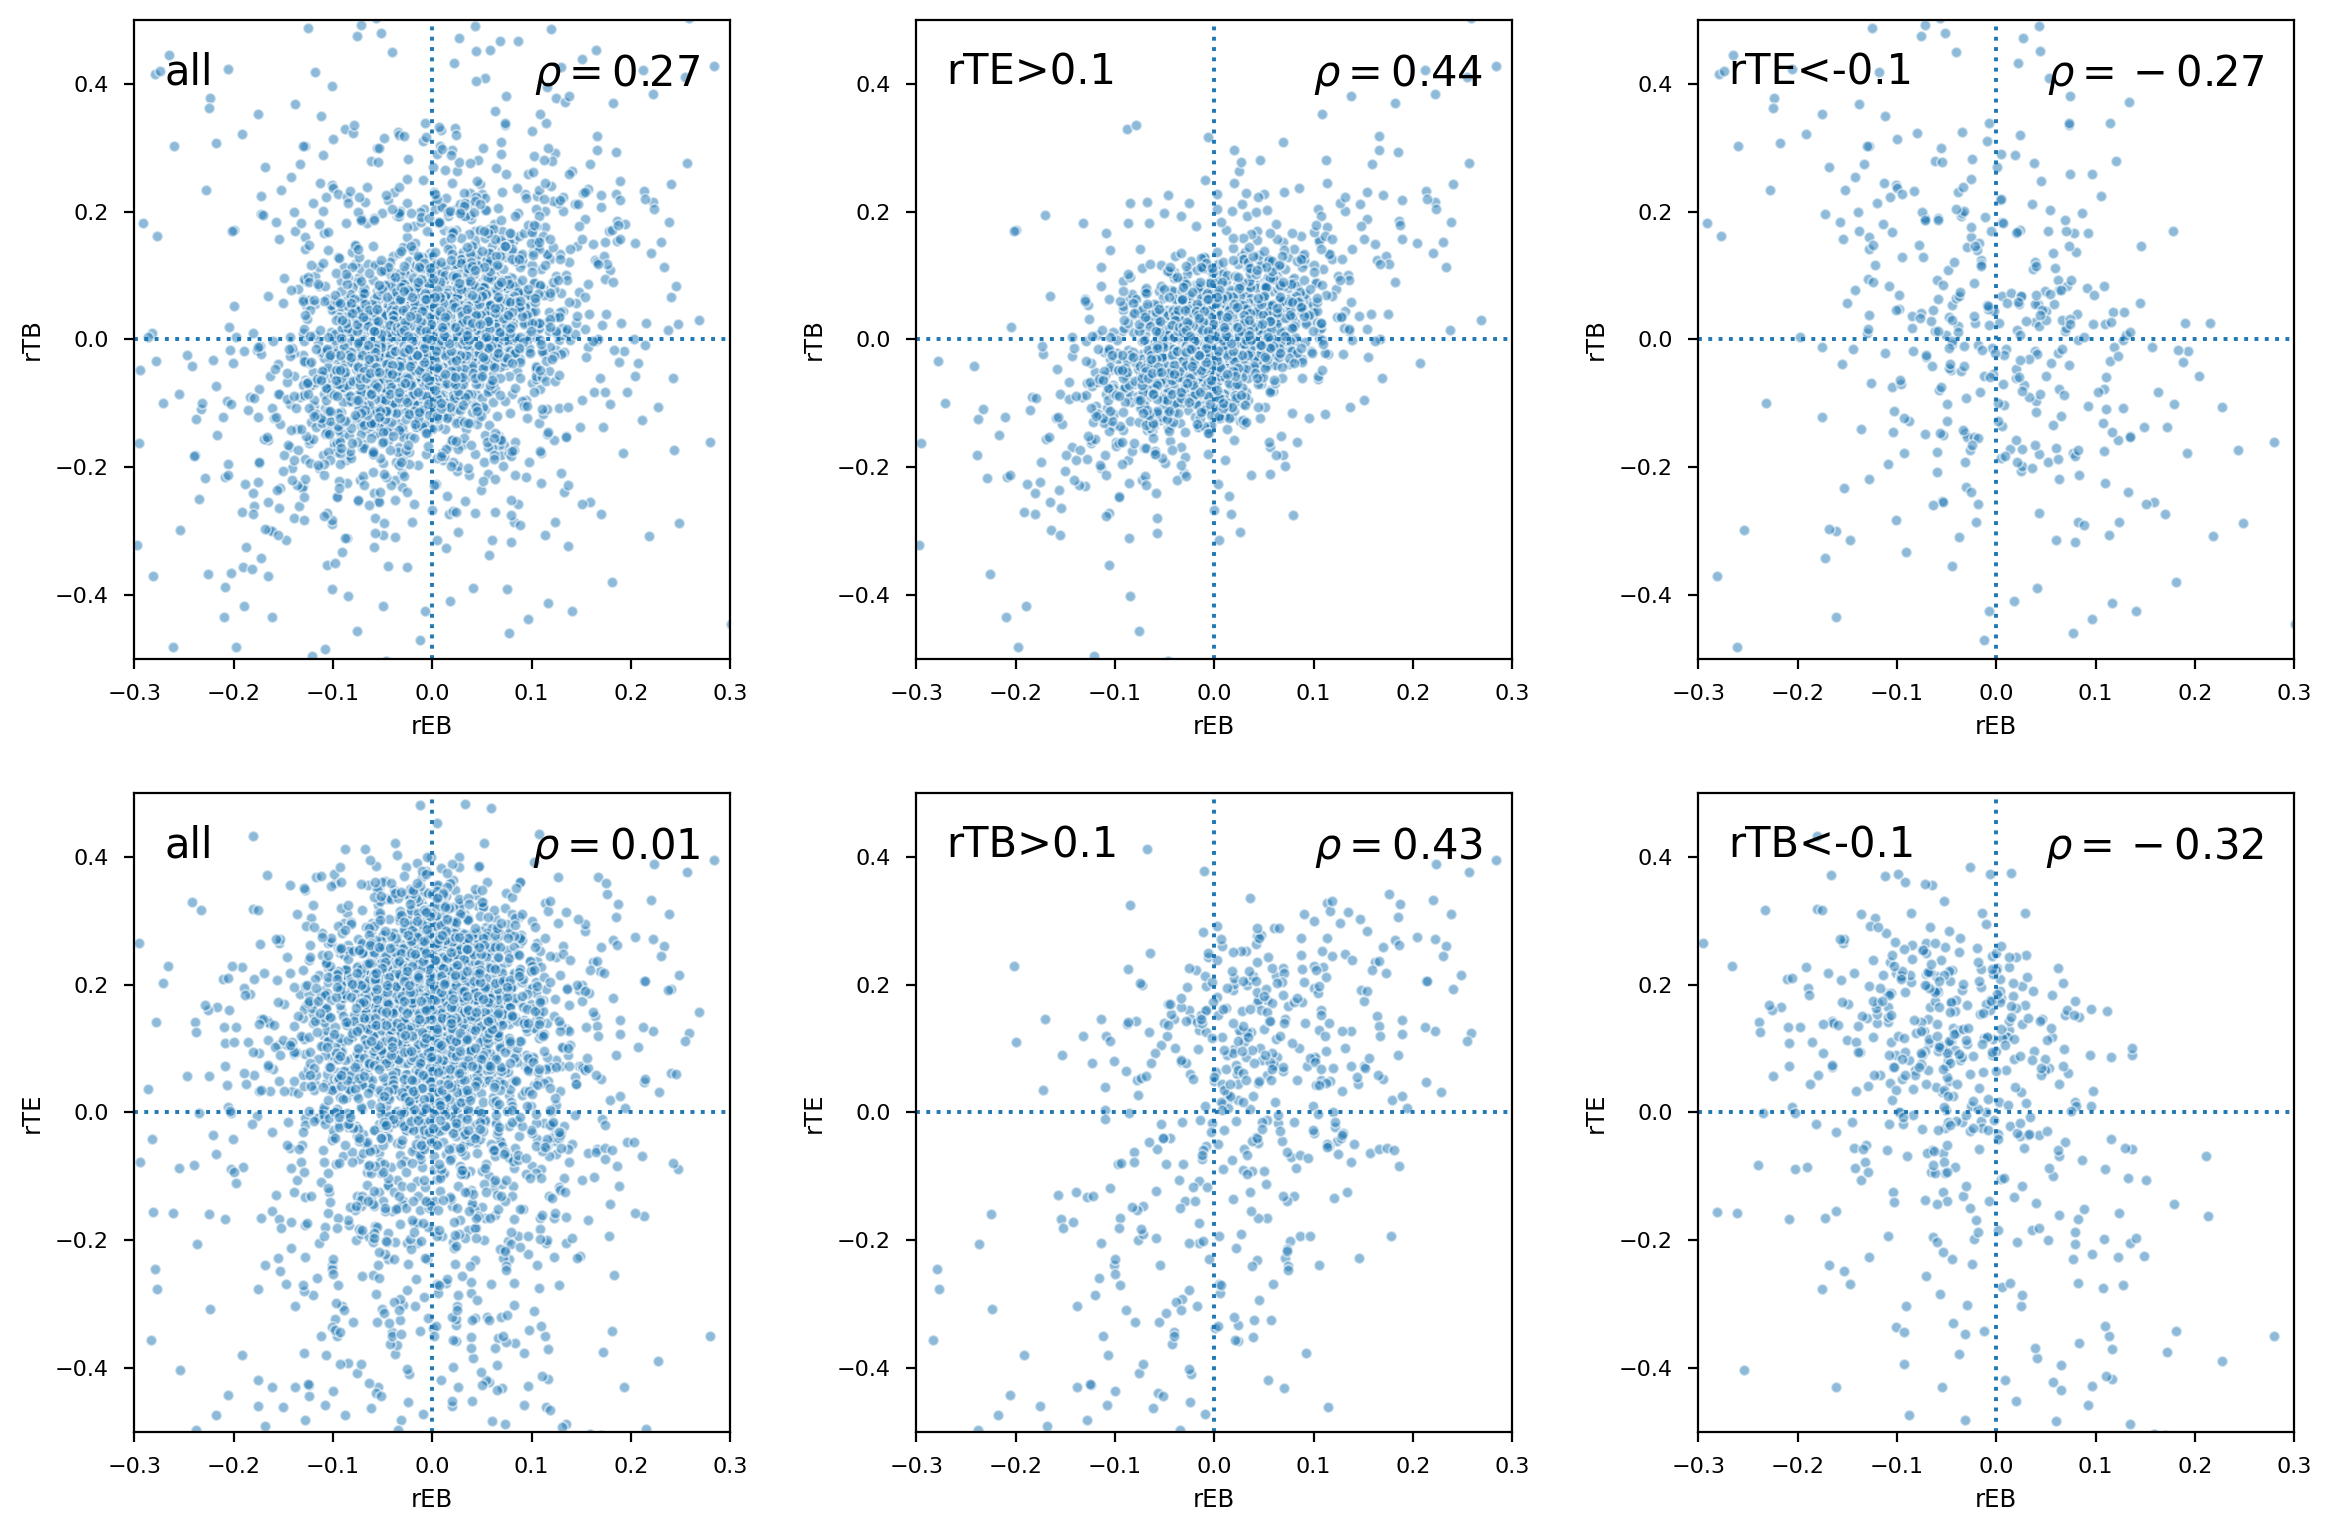

In [52]:
corr_method='spearman'
# corr_method='pearson'
# corr_method='kendall'
with plt.style.context(['seaborn-paper',{'figure.dpi':200,'font.size':18}],after_reset=True):
    dfpTE = df.where(df.rTE>0.1)[['rTB','rEB']]
    dfnTE = df.where(df.rTE<-0.1)[['rTB','rEB']]
    dfpTB = df.where(df.rTB>0.1)[['rTE','rEB']]
    dfnTB = df.where(df.rTB<-0.1)[['rTE','rEB']]
    fig,axes = plt.subplots(2,3,figsize=(12,8))
    for ax,x,y,df_,lab in zip(axes.flat,
                             ['rEB','rEB','rEB','rEB','rEB','rEB'],
                             ['rTB','rTB','rTB','rTE','rTE','rTE'],
                             [df,dfpTE,dfnTE,df,dfpTB,dfnTB],
                              ['all','rTE>0.1','rTE<-0.1','all','rTB>0.1','rTB<-0.1']
                             ):
        plt.sca(ax)
        sns.scatterplot(x,y,data=df_,alpha=0.5, s=15)
        corr = df_.corr(method='spearman')

        plt.annotate(lab,(0.05,0.95),ha='left',va='top',xycoords='axes fraction',fontsize='small')
        plt.annotate(r'$\rho={:.2f}$'.format(corr[x][y]),(0.95,0.95),
                     ha='right',va='top',xycoords='axes fraction',fontsize='small')
        plt.axhline(0,ls=':')
        plt.axvline(0,ls=':')
        plt.xlim(-0.3,0.3)
        plt.ylim(-0.5,0.5)
#         ax.set_aspect('equal')
    plt.tight_layout()

rEB rTB 0.8044218287173144 0.0026690884676967724
rTB rEB 0.5317232160556369 -0.0035135556440368245
941
rEB rTB -0.9199494126613024 0.03388613935102151
rTB rEB -0.19143255295263767 -0.004000546156148546
249
rEB rTE 1.2923370075830825 -0.0944456549350359
rTE rEB 0.33945864976620654 0.043739396220369695
222
rEB rTE -0.8378842547544448 -0.08701780400764766
rTE rEB -0.29856085413735206 -0.0699481032416504
170


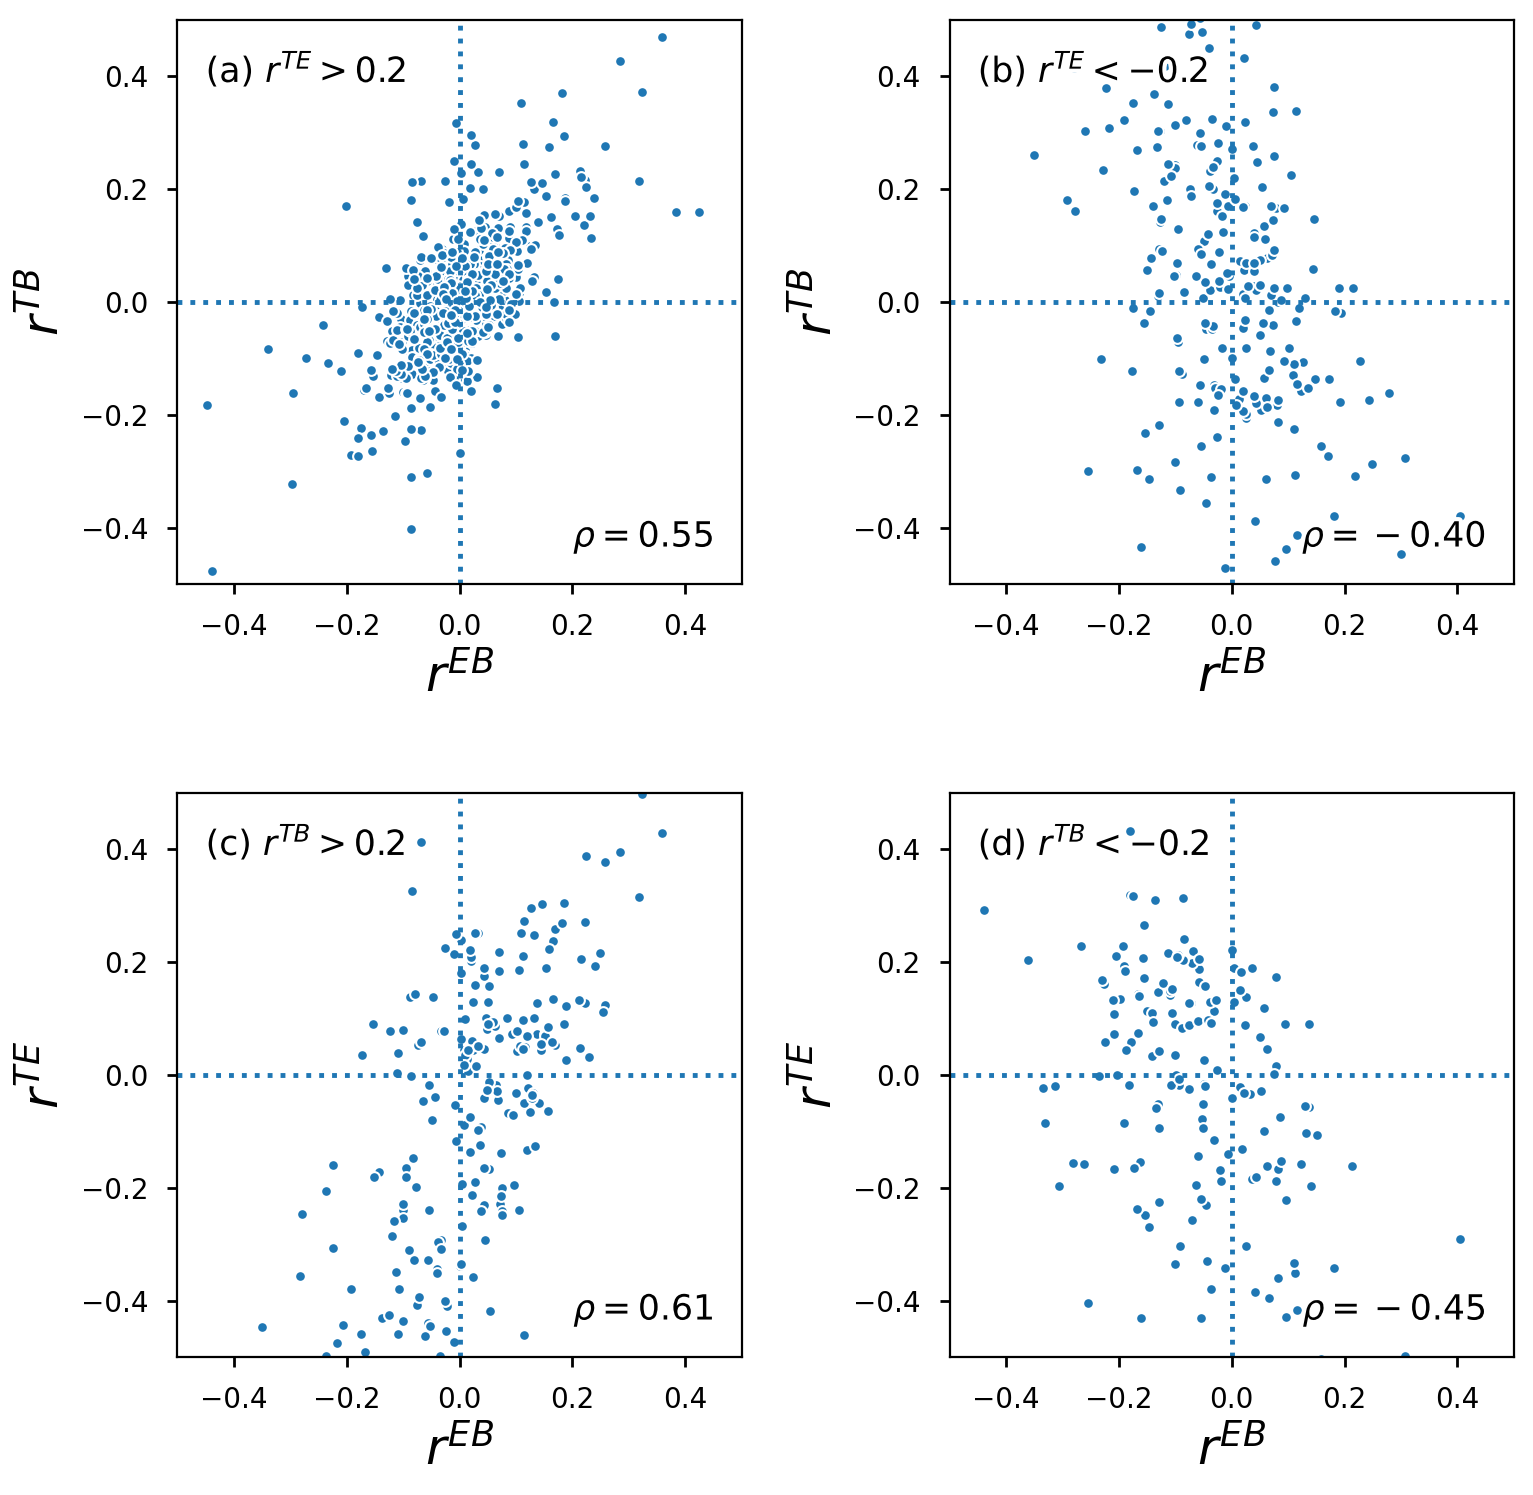

In [83]:
from scipy import stats

corr_method='spearman'
# corr_method='pearson'
# corr_method='kendall'
with plt.style.context(['seaborn-notebook',{'figure.dpi':200,'font.size':18,'axes.labelsize':'medium'}],after_reset=True):
    dfpTE = df.where(df.rTE>0.2)[['rTB','rEB']]
    dfnTE = df.where(df.rTE<-0.2)[['rTB','rEB']]
    dfpTB = df.where(df.rTB>0.2)[['rTE','rEB']]
    dfnTB = df.where(df.rTB<-0.2)[['rTE','rEB']]
    fig,axes = plt.subplots(2,2,figsize=(8,8))
    for ax,x,y,df_,lab in zip(axes.flat,
                             ['rEB','rEB','rEB','rEB'],
                             ['rTB','rTB','rTE','rTE'],
                             [dfpTE,dfnTE,dfpTB,dfnTB],
                              ['(a) $r^{TE}>0.2$','(b) $r^{TE}<-0.2$','(c) $r^{TB}>0.2$','(d) $r^{TB}<-0.2$']
                             ):
        plt.sca(ax)
        sns.scatterplot(x,y,data=df_, s=15)
#         sns.regplot(x,y,data=df_,scatter_kws=dict(alpha=0.5, s=15))
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_[x].dropna(),df_[y].dropna())
        print(x,y,slope,intercept)
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_[y].dropna(),df_[x].dropna())
        print(y,x,slope,intercept)

        corr = df_.corr(method=corr_method)
        print(len(df_.dropna()))
        plt.annotate(lab,(0.05,0.95),ha='left',va='top',xycoords='axes fraction',fontsize='x-small',
                     path_effects=[withStroke(foreground='w',linewidth=3)])
        plt.annotate(r'$\rho={:.2f}$'.format(corr[x][y]),(0.95,0.05),
                     ha='right',va='bottom',xycoords='axes fraction',fontsize='x-small',
                     path_effects=[withStroke(foreground='w',linewidth=3)])
        plt.axhline(0,ls=':')
        plt.axvline(0,ls=':')
        plt.xlim(-0.5,0.5)
        plt.ylim(-0.5,0.5)
#         plt.plot([-0.3,0.3],[-0.6,0.6])
#         plt.plot([-0.3,0.3],[0.6,-0.6])
        plt.xlabel(labels_dict[x])
        plt.ylabel(labels_dict[y])
        ax.set_aspect('equal')
    plt.tight_layout()
    fig.savefig('../figures/correlation_{}_{}.png'.format(corr_method,bcut),bbox_inches='tight',dpi=200)

In [17]:
import linmix

In [19]:
dfpTE['rTB']

0      -0.016401
1       0.008776
2      -0.035056
3       0.005321
4       0.021719
          ...   
3145         NaN
3146    0.005125
3147    0.007336
3148    0.019044
3149    0.062809
Name: rTB, Length: 3150, dtype: float64

In [31]:
lm= linmix.LinMix(dfpTE['rEB'].dropna(), dfpTE['rTB'].dropna(), 0.01, 0.01, K=2)
lm.run_mcmc(silent=False)


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.9973963  0.99627516 0.99911674 1.00196627 1.00941389 0.99675794]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99706519 0.99579085 1.00057377 0.99838235 0.99880006 0.99682632]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99752717 0.99745781 1.00024989 0.99764099 0.99851784 0.99832453]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99785457 0.99860341 0.99922657 0.99798514 0.9994488  0.99887289]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.9992628  0.99897105 0.9992361  0.99853075 1.00001078 0.99905668]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99958518 0.99883897 0


Iteration:  4800
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99985198 1.00006384 1.00010541 0.99980304 0.99983353 1.00008674]

Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99989845 1.00003786 1.00007633 0.99980068 0.99982696 1.00004977]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99987576 1.00003853 1.00010872 0.99980308 0.99982824 1.00006547]


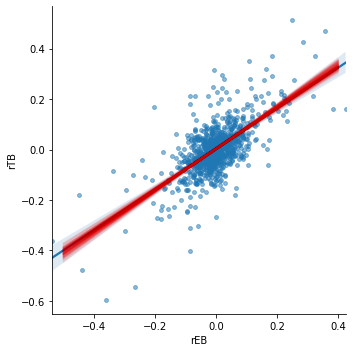

In [46]:
g = sns.lmplot('rEB','rTB',data=dfpTE,scatter_kws=dict(alpha=0.5, s=15))

# plt.sca(g.ax)
for i in range(0, len(lm.chain), 25):
    xs = np.arange(-0.5,0.5,0.1)
    ys = lm.chain[i]['alpha'] + xs * lm.chain[i]['beta']
    plt.plot(xs, ys, color='r', alpha=0.02)

In [44]:
xs

array([-0.5])

In [39]:
g.ax

In [35]:
import corner

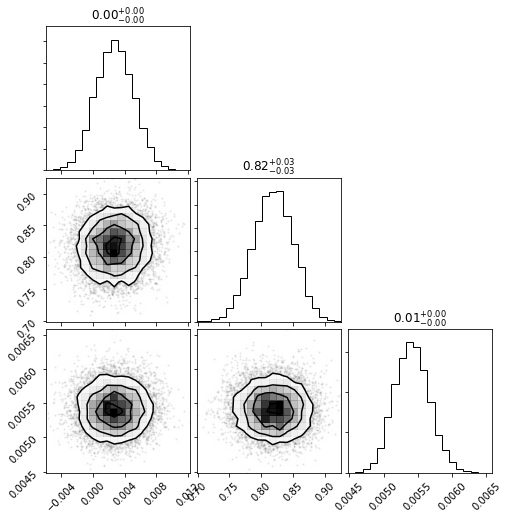

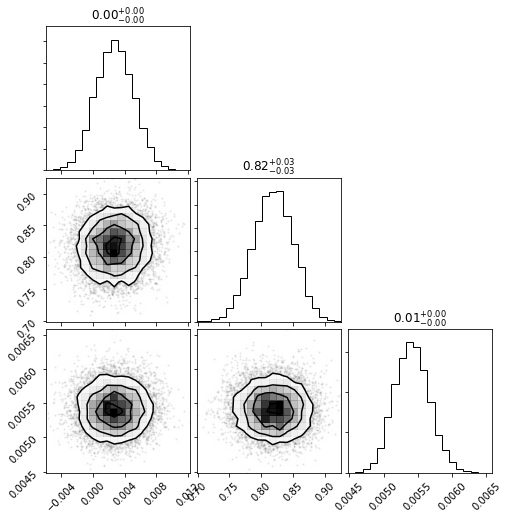

In [37]:
corner.corner(np.array([lm.chain['alpha'],lm.chain['beta'],lm.chain['sigsqr']]).T,show_titles=True)